# Concrete Surface Crack Detection

# **1. Import Libraries and Set Directories**

## 1.1 Import Libraries

In [ ]:
# Import necessary libraries
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import time
import warnings

from PIL import Image
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, accuracy_score, log_loss

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import resnet50, efficientnet, densenet, mobilenet_v2

warnings.filterwarnings("ignore")


## 1.2 Define Directories

In [ ]:
import os

# Check if running on Kaggle
is_kaggle = os.path.exists('/kaggle/input')

# Define base directories based on environment
if is_kaggle:
    base_dir = '/kaggle/input/concrete-crack-images/concerete_crack_images'
else:
    base_dir = 'concrete_crack_images'

# Create all paths using os.path.join for better cross-platform compatibility
train_dir = os.path.join(base_dir, 'training')
test_dir = os.path.join(base_dir, 'test')
train_positive_dir = os.path.join(base_dir, 'training', 'Positive')
train_negative_dir = os.path.join(base_dir, 'training', 'Negative')

print("Train Positive Directory Exists:", os.path.exists(train_positive_dir))
print("Train Negative Directory Exists:", os.path.exists(train_negative_dir))

Train Positive Directory Exists: True
Train Negative Directory Exists: True


# **2. Data Inspection**

## 2.1 Count Image Files

Training Data:
  Positive samples: 16070
  Negative samples: 16037
  Total training images: 32107

Test Data:
  Total test images: 7893



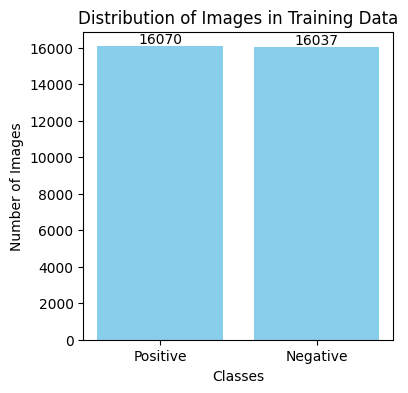

In [37]:
# count images function
def count_images(directory):
    supported_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')
    return len([file for file in os.listdir(directory) if file.lower().endswith(supported_extensions)])

# Check training data
num_train_positive = count_images(train_positive_dir)
num_train_negative = count_images(train_negative_dir)

print(f"Training Data:")
print(f"  Positive samples: {num_train_positive}")
print(f"  Negative samples: {num_train_negative}")
print(f"  Total training images: {num_train_positive + num_train_negative}\n")

# Check test data
num_test = count_images(test_dir)
print(f"Test Data:")
print(f"  Total test images: {num_test}\n")

# Plot training image distribution with numbers on bars
plt.figure(figsize=(4, 4))
bar_positions = ['Positive', 'Negative']
bar_heights = [num_train_positive, num_train_negative]
bars = plt.bar(bar_positions, bar_heights, color='skyblue')

# Add numbers on top of each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, 
             str(bar.get_height()), ha='center', va='bottom', fontsize=10)

plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Distribution of Images in Training Data')
plt.show()


## 2.2 Check Image Properties

In [38]:
# Check image sizes
def check_image_sizes(directory, extension='.jpg'):
    sizes = []
    for file in os.listdir(directory):
        if file.lower().endswith(extension):
            img_path = os.path.join(directory, file)
            with Image.open(img_path) as img:
                sizes.append(img.size)
    unique_sizes = set(sizes)
    print(f"Unique image sizes in {directory}: {unique_sizes}")

check_image_sizes(train_positive_dir)
check_image_sizes(train_negative_dir)
check_image_sizes(test_dir, extension='.png')

Unique image sizes in /kaggle/input/concrete-crack-images/concerete_crack_images/training/Positive: {(227, 227)}
Unique image sizes in /kaggle/input/concrete-crack-images/concerete_crack_images/training/Negative: {(227, 227)}
Unique image sizes in /kaggle/input/concrete-crack-images/concerete_crack_images/test: {(227, 227)}


In [39]:
# Check color modes
def check_color_modes(directory, extension='.jpg'):
    color_modes = []
    for file in os.listdir(directory):
        if file.lower().endswith(extension):
            img_path = os.path.join(directory, file)
            with Image.open(img_path) as img:
                color_modes.append(img.mode)
    unique_modes = set(color_modes)
    print(f"Unique color modes in {directory}: {unique_modes}")

check_color_modes(train_positive_dir)
check_color_modes(train_negative_dir)
check_color_modes(test_dir, extension='.png')

Unique color modes in /kaggle/input/concrete-crack-images/concerete_crack_images/training/Positive: {'RGB'}
Unique color modes in /kaggle/input/concrete-crack-images/concerete_crack_images/training/Negative: {'RGB'}
Unique color modes in /kaggle/input/concrete-crack-images/concerete_crack_images/test: {'RGB'}


In [40]:
# Check corrupted images
def check_corrupted_images(directory, extension='.jpg'):
    corrupted_files = []
    for file in os.listdir(directory):
        if file.lower().endswith(extension):
            img_path = os.path.join(directory, file)
            try:
                with Image.open(img_path) as img:
                    img.verify()  # Verify image integrity
            except Exception:
                corrupted_files.append(file)
    if corrupted_files:
        print(f"Corrupted images in {directory}: {corrupted_files}")
    else:
        print(f"No corrupted images found in {directory}.")


check_corrupted_images(train_positive_dir)
check_corrupted_images(train_negative_dir)
check_corrupted_images(test_dir, extension='.png')

No corrupted images found in /kaggle/input/concrete-crack-images/concerete_crack_images/training/Positive.
No corrupted images found in /kaggle/input/concrete-crack-images/concerete_crack_images/training/Negative.
No corrupted images found in /kaggle/input/concrete-crack-images/concerete_crack_images/test.


## 2.3 Display Sample Images

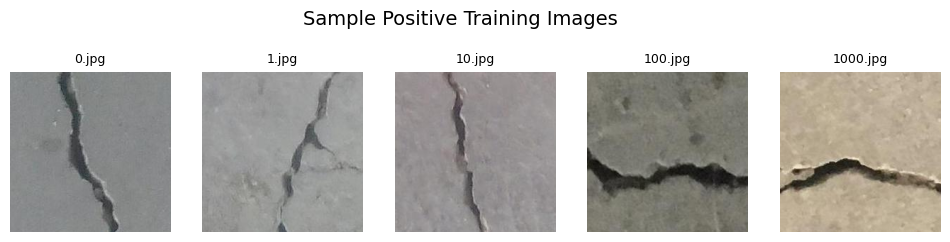

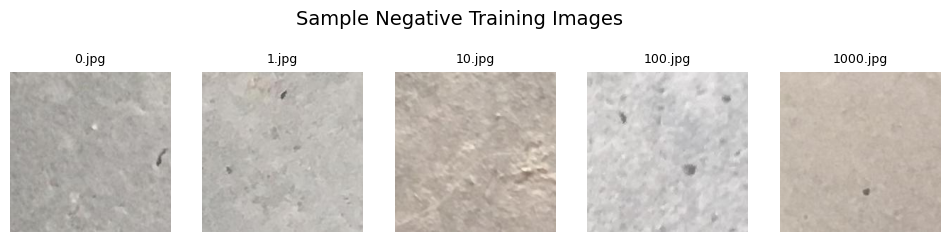

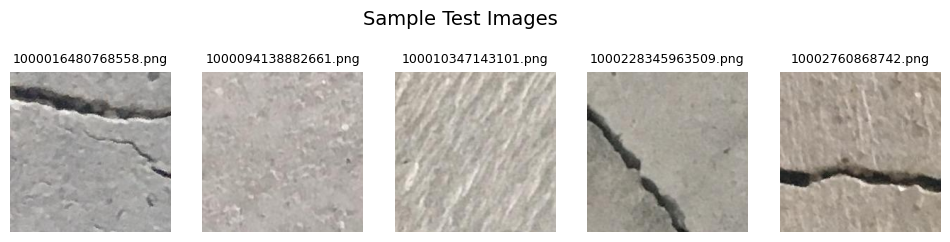

In [41]:
# plot sample images
def load_images(directory, n=5, extension='.jpg'):
    files = sorted([f for f in os.listdir(directory) if f.lower().endswith(extension)])
    images = [Image.open(os.path.join(directory, file)) for file in files[:n]]
    return images, files[:n]

def plot_images(images, titles, main_title):
    plt.figure(figsize=(12, 4))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(title, fontsize=9)
    plt.suptitle(main_title, fontsize=14, y=0.85)  # Reduce vertical space below the title
    plt.show()

pos_images, pos_names = load_images(train_positive_dir)
plot_images(pos_images, pos_names, 'Sample Positive Training Images')

neg_images, neg_names = load_images(train_negative_dir)
plot_images(neg_images, neg_names, 'Sample Negative Training Images')

test_images, test_names = load_images(test_dir, extension='.png')
plot_images(test_images, test_names, 'Sample Test Images')

# **3. Helper Functions**

## 3.1. Data Preprocessing

In [42]:
# image processing functions
def gen(pre, train_dir, test_dir, image_size=(224, 224), batch_size=32, class_mode='binary', seed=6105):
    train_datagen = ImageDataGenerator(
        preprocessing_function=pre,
        validation_split=0.2,
        # rotation_range=20,  
        # width_shift_range=0.2,  
        # height_shift_range=0.2,     
        # shear_range=0.2,    
        # zoom_range=0.2,
        # horizontal_flip=True,
        # fill_mode='nearest'
        )
    
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode=class_mode,
        subset='training',
        seed=seed,
        shuffle=True,
        )
    
    val_datagen = ImageDataGenerator(
    preprocessing_function=pre, 
    validation_split=0.2
    )

    val_generator = val_datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode=class_mode,
        subset='validation',
        seed=seed,
        shuffle=False,
        )
    
    # test_datagen = ImageDataGenerator(preprocessing_function=pre)

    # test_filenames = [f for f in os.listdir(test_dir) if os.path.isfile(os.path.join(test_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    # test_df = pd.DataFrame({'filename': test_filenames})
    
    # test_generator = test_datagen.flow_from_dataframe(
    #     dataframe=test_df,
    #     directory=test_dir,
    #     x_col='filename',
    #     y_col=None,
    #     target_size=image_size,
    #     batch_size=batch_size,
    #     class_mode=None,
    #     shuffle=False,
    #     seed=seed
    # )

    # # for now
    test_generator = None
    
    return train_generator, val_generator, test_generator

## 3.2 Build and Fit Model

In [43]:
def build_and_fit_model(
    base_model_name=None,  # For transfer learning, pass the base model class
    input_shape=None,  # Required input shape
    num_classes=1, 
    output_activation='sigmoid', 
    dropout=0.5, 
    initial_lr=1e-4, 
    trainable=False,  # Whether to fine-tune the base model
    train_generator=None, 
    val_generator=None, 
    epochs=30
):

    if base_model_name:
        # Transfer learning model
        base_model = base_model_name(weights='imagenet', include_top=False, input_shape=input_shape)
        base_model.trainable = trainable

        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(dropout),
            Dense(num_classes, activation=output_activation)
        ])
    else:
        # Custom model
        model = Sequential([
            Input(shape=input_shape),

            Conv2D(32, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),

            Conv2D(64, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),

            Conv2D(128, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),

            Conv2D(256, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),

            Flatten(),
            Dense(128, activation='relu'),
            Dropout(dropout),
            Dense(num_classes, activation=output_activation)
        ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=initial_lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stop = EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        patience=10, 
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', 
        mode='min', 
        factor=0.2,
        patience=5,
        cooldown=3,
        min_lr=1e-7
    )

    checkpoint = ModelCheckpoint(
        f"best_model_{'CustomModel' if not base_model_name else base_model_name.__name__}.keras",
        monitor='val_loss',
        save_best_only=True,
        verbose=0
    )

    # Fit the model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[early_stop, reduce_lr, checkpoint]
    )

    return model, history


## 3.3 Predict on Validation Set

In [44]:
def predict_on_val(model, dataset, threshold=0.5):
    # Predict probabilities and classes
    y_pred = model.predict(dataset, verbose=1)
    y_pred_classes = (y_pred > threshold).astype(int).reshape(-1)

    # Extract true labels and file paths
    y_true = dataset.classes[:len(y_pred_classes)]
    file_paths = dataset.filepaths[:len(y_pred_classes)] 

    # Identify misclassified samples
    misclassified_samples = []
    for i in range(len(y_true)):
        if y_pred_classes[i] != y_true[i]: 
            misclassified_samples.append({
                'file': file_paths[i],  
                'true_label': y_true[i],
                'predicted_label': y_pred_classes[i],
                'probability': y_pred[i][0]  
            })

    print(f"Number of misclassified samples: {len(misclassified_samples)}")
    
    return y_pred, y_pred_classes, y_true, misclassified_samples


## 3.4 Visualization

In [45]:
# Print classification report
def print_classification_report(y_true, y_pred_classes, target_names, model_name):

    print(f"[{model_name}] Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=target_names))

# Calculate and plot ROC curve
def plot_roc(y_true, y_pred, model_name):
    auc = roc_auc_score(y_true, y_pred)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"[{model_name}] Validation ROC Curve")
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred_classes, model_name):
    cm = confusion_matrix(y_true, y_pred_classes)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 4))
    
    # Plot original confusion matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"[{model_name}] Validation Confusion Matrix")
    
    # Plot normalized confusion matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"[{model_name}] Validation Normalized Confusion Matrix")

    plt.tight_layout()
    plt.show()


# Plot training history
def plot_training_history(history, model_name):
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Plot accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"[{model_name}] Training and Validation Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(epochs) 
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title(f"[{model_name}] Training and Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs, [str(epoch) for epoch in epochs]) 
    plt.legend()
    plt.grid(True)
    plt.show()



def plot_misclassified_samples(misclassified_samples, max_images=20):
    fp_samples = [sample for sample in misclassified_samples if sample['true_label'] == 0 and sample['predicted_label'] == 1]
    fn_samples = [sample for sample in misclassified_samples if sample['true_label'] == 1 and sample['predicted_label'] == 0]

    def plot_samples(samples, title, max_images):
        num_samples = min(len(samples), max_images)
        cols = 5
        rows = (num_samples + cols - 1) // cols

        plt.figure(figsize=(cols * 3, rows * 3))
        plt.suptitle(title, fontsize=16, y=1.02)

        for i in range(num_samples):
            sample = samples[i]
            img = Image.open(sample['file'])

            plt.subplot(rows, cols, i + 1)
            plt.imshow(img)
            plt.title(f"True: {sample['true_label']}, Pred: {sample['predicted_label']}\nProb: {sample['probability']:.2f}")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

    # Plot False Positive
    if fp_samples:
        print(f"Number of False Positives: {len(fp_samples)}")
        plot_samples(fp_samples, "False Positives (FP)", max_images)

    # Plot False Negative
    if fn_samples:
        print(f"Number of False Negatives: {len(fn_samples)}")
        plot_samples(fn_samples, "False Negatives (FN)", max_images)


# **4. Custom Model**

## 4.1 ⭐️Set Hyperparameters

In [46]:
# set hyperparameters
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 256
EPOCHS = 30

## 4.2 Data Processing

In [47]:
train_generator_custom, val_generator_custom, test_generator_custom = gen(
    lambda x: x / 255, 
    train_dir, 
    test_dir, 
    image_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE, 
)


Found 25686 images belonging to 2 classes.
Found 6421 images belonging to 2 classes.


## 4.3 Build and Fit Model

In [48]:
# Start time
custom_start_time = time.time()

# Build and fit custom model
custom_model, custom_history = build_and_fit_model(
    input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3), 
    train_generator=train_generator_custom, 
    val_generator=val_generator_custom, 
    epochs=EPOCHS
)

# End time
custom_end_time = time.time()
# Calculate average time per epoch
custom_total_time = int(custom_end_time - custom_start_time)
custom_num_epochs = len(custom_history.history['loss'])
custom_avg_epoch_time = custom_total_time // custom_num_epochs
print("Average epoch time of Custom Model:", custom_avg_epoch_time, "seconds")
print("Total number of epochs:", custom_num_epochs)
print("Total time of Custom Model:", custom_total_time, "seconds")

Epoch 1/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 55s 467ms/step - accuracy: 0.9139 - loss: 0.2655 - val_accuracy: 0.4995 - val_loss: 4.6530 - learning_rate: 1.0000e-04
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 78s 748ms/step - accuracy: 0.9929 - loss: 0.0217 - val_accuracy: 0.4995 - val_loss: 4.6661 - learning_rate: 1.0000e-04
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 59s 550ms/step - accuracy: 0.9961 - loss: 0.0127 - val_accuracy: 0.6125 - val_loss: 1.3313 - learning_rate: 1.0000e-04
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 48s 447ms/step - accuracy: 0.9967 - loss: 0.0097 - val_accuracy: 0.9618 - val_loss: 0.1067 - learning_rate: 1.0000e-04
Epoch 5/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 51s 471ms/step - accuracy: 0.9973 - loss: 0.0081 - val_accuracy: 0.9936 - val_loss: 0.0210 - learning_rate: 1.0000e-04
Epoch 6/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 48s 446ms/step - accuracy: 0.9984 - loss: 0.0061 - val_accuracy: 0.9945 - val_loss: 0.0191 - learning_rate: 1.0000e-04
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 46s 43

## 4.4 Prediction and Visualization

26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 352ms/step
Number of misclassified samples: 20
[Custom Model] Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      3207
    Positive       1.00      1.00      1.00      3214

    accuracy                           1.00      6421
   macro avg       1.00      1.00      1.00      6421
weighted avg       1.00      1.00      1.00      6421



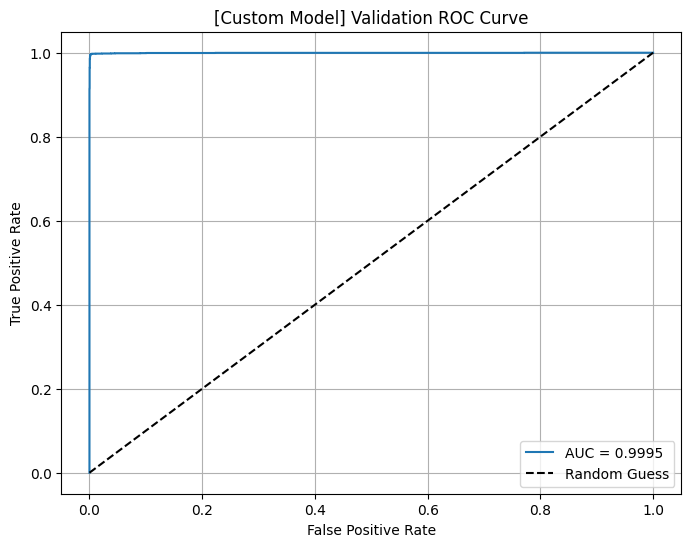

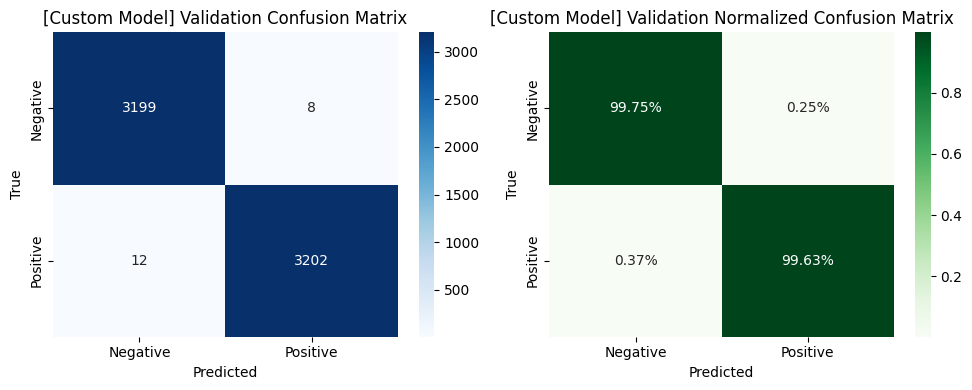

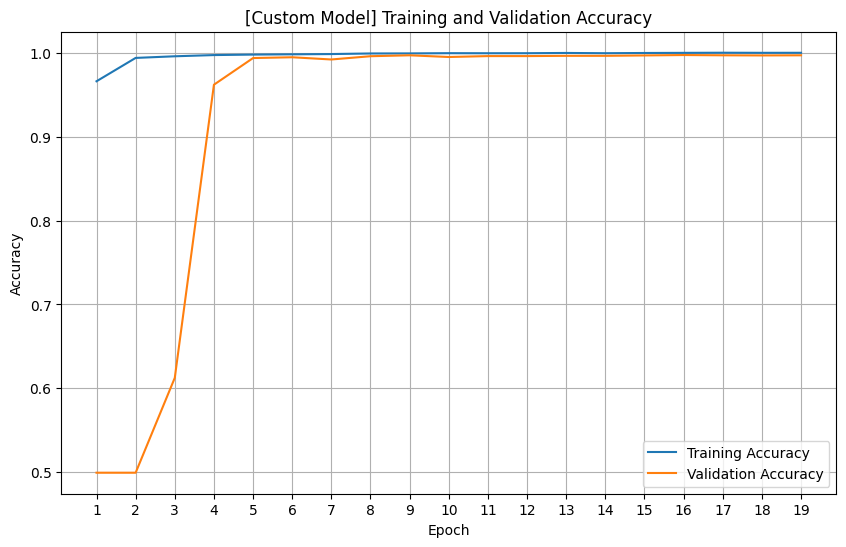

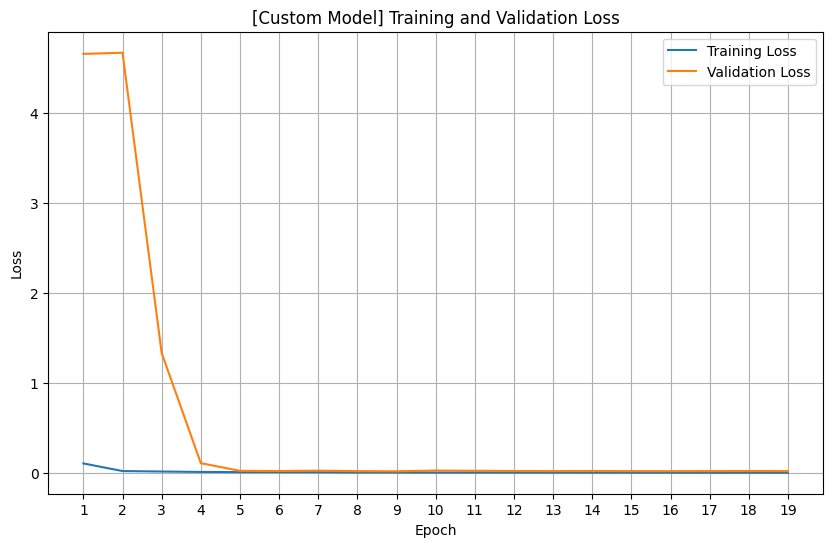

Number of False Positives: 8


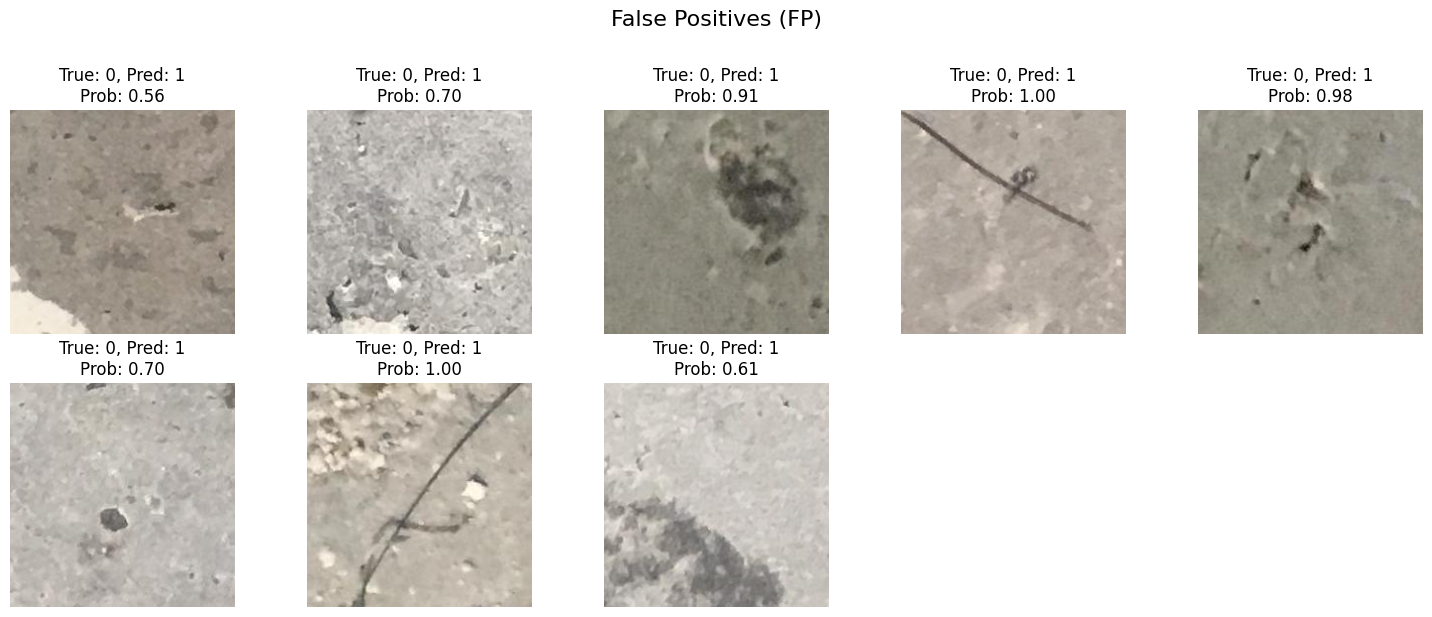

Number of False Negatives: 12


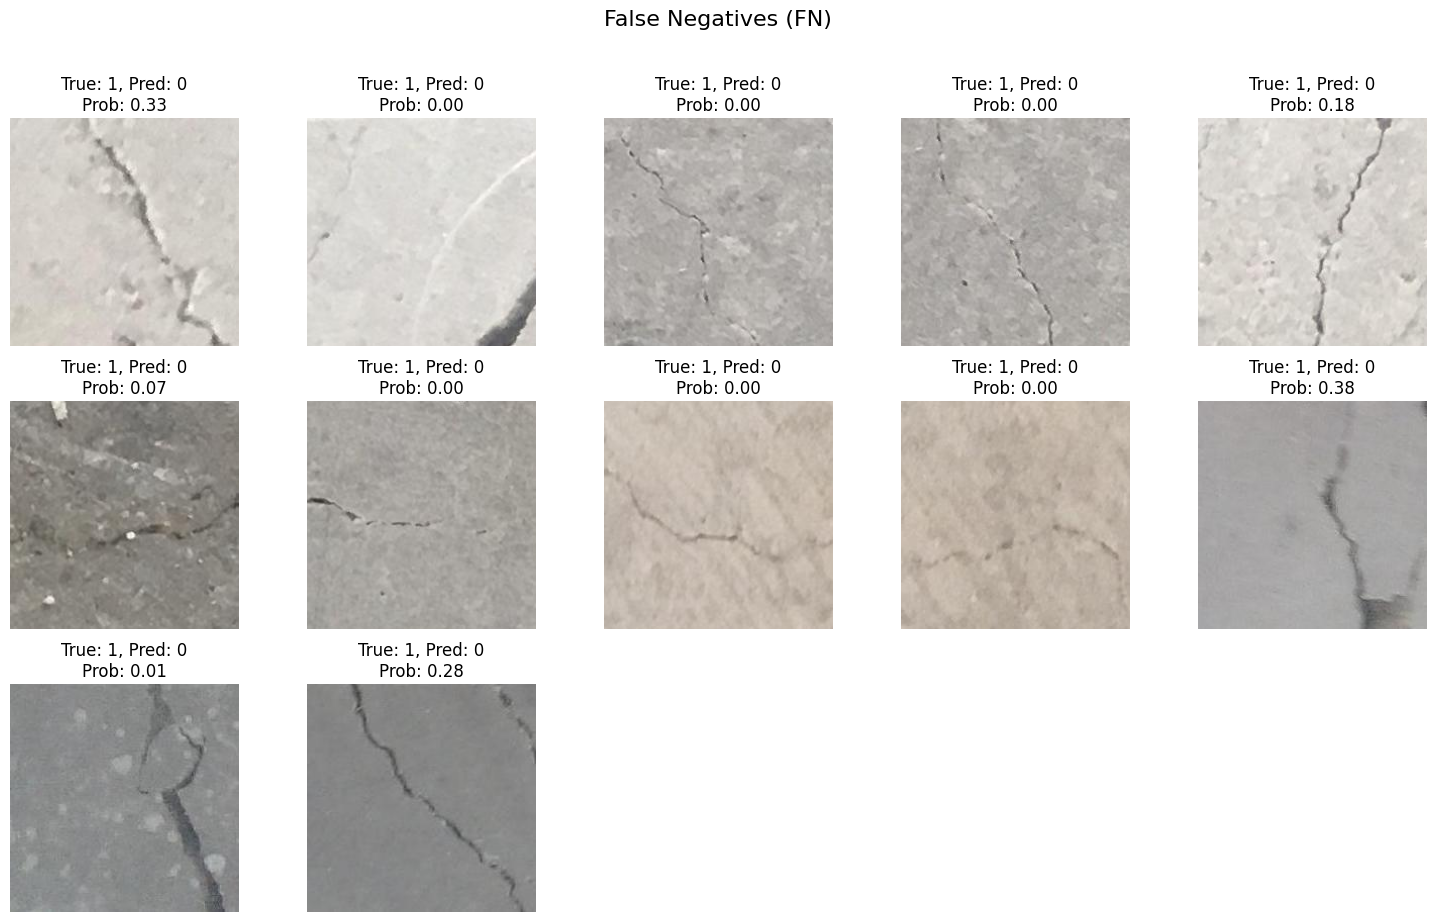

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,461,317 (28.46 MB)

 Trainable params: 2,486,785 (9.49 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 4,973,572 (18.97 MB)

In [49]:
# Predict on validation data
custom_y_pred, custom_y_pred_classes, custom_y_true, custom_mis = predict_on_val(custom_model, val_generator_custom)

# Visulization
print_classification_report(custom_y_true, custom_y_pred_classes, ['Negative', 'Positive'], 'Custom Model')
plot_roc(custom_y_true, custom_y_pred, 'Custom Model')
plot_confusion_matrix(custom_y_true, custom_y_pred_classes, 'Custom Model')
plot_training_history(custom_history, 'Custom Model')
plot_misclassified_samples(custom_mis, max_images=20)

custom_model.summary()

# **5. Transfer Learning**

## 5.1 ⭐️Set Hyperparameters

In [50]:
# set hyperparameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30

## 5.2 ResNet50

In [51]:
# Generate data
train_generator_resnet, val_generator_resnet, test_generator_resnet = gen(resnet50.preprocess_input, train_dir, test_dir, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)

# Start time
resnet_start_time = time.time()

# Build and fit model
resnet_model, resnet_history = build_and_fit_model(resnet50.ResNet50, train_generator=train_generator_resnet, val_generator=val_generator_resnet, epochs=EPOCHS)

# End time
resnet_end_time = time.time()
# Calculate average epoch time
resnet_total_time = int(resnet_end_time - resnet_start_time)
resnet_num_epochs = len(resnet_history.history['loss'])
resnet_avg_epoch_time = resnet_total_time // resnet_num_epochs
print("Average epoch time of Resnet50:", resnet_avg_epoch_time, "seconds")
print("Total time of Resnet50:", resnet_total_time, "seconds")

# Predict on validation set
resnet_y_pred, resnet_y_pred_classes, resnet_y_true, resnet_mis = predict_on_val(resnet_model, val_generator_resnet)

Found 25686 images belonging to 2 classes.
Found 6421 images belonging to 2 classes.
Epoch 1/30
803/803 ━━━━━━━━━━━━━━━━━━━━ 79s 86ms/step - accuracy: 0.9836 - loss: 0.0390 - val_accuracy: 0.9977 - val_loss: 0.0089 - learning_rate: 1.0000e-04
Epoch 2/30
803/803 ━━━━━━━━━━━━━━━━━━━━ 71s 87ms/step - accuracy: 0.9976 - loss: 0.0073 - val_accuracy: 0.9986 - val_loss: 0.0067 - learning_rate: 1.0000e-04
Epoch 3/30
803/803 ━━━━━━━━━━━━━━━━━━━━ 63s 78ms/step - accuracy: 0.9992 - loss: 0.0041 - val_accuracy: 0.9980 - val_loss: 0.0082 - learning_rate: 1.0000e-04
Epoch 4/30
803/803 ━━━━━━━━━━━━━━━━━━━━ 65s 80ms/step - accuracy: 0.9990 - loss: 0.0046 - val_accuracy: 0.9984 - val_loss: 0.0070 - learning_rate: 1.0000e-04
Epoch 5/30
803/803 ━━━━━━━━━━━━━━━━━━━━ 74s 92ms/step - accuracy: 0.9990 - loss: 0.0035 - val_accuracy: 0.9983 - val_loss: 0.0079 - learning_rate: 1.0000e-04
Epoch 6/30
803/803 ━━━━━━━━━━━━━━━━━━━━ 68s 84ms/step - accuracy: 0.9994 - loss: 0.0020 - val_accuracy: 0.9983 - val_loss: 0.

[ResNet50] Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      3207
    Positive       1.00      1.00      1.00      3214

    accuracy                           1.00      6421
   macro avg       1.00      1.00      1.00      6421
weighted avg       1.00      1.00      1.00      6421



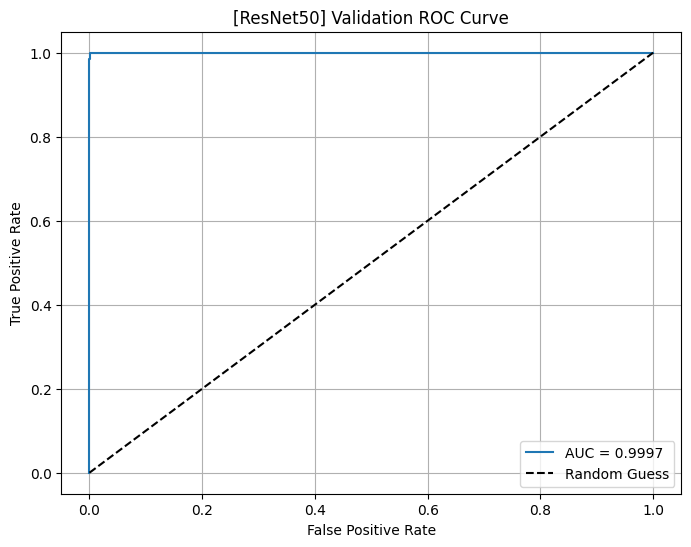

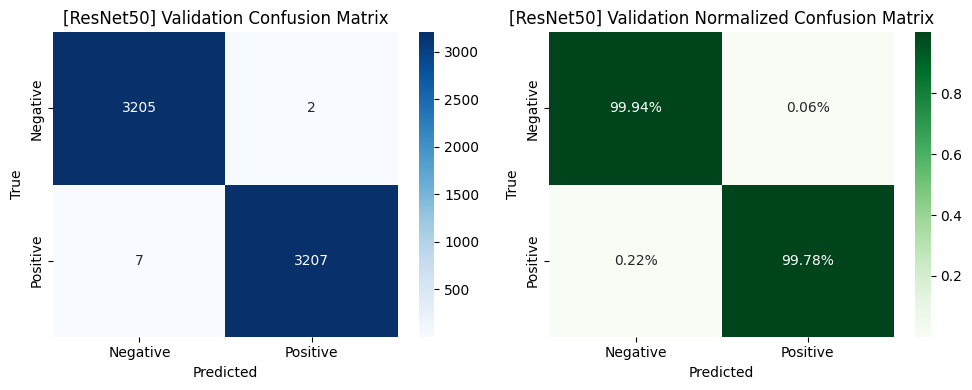

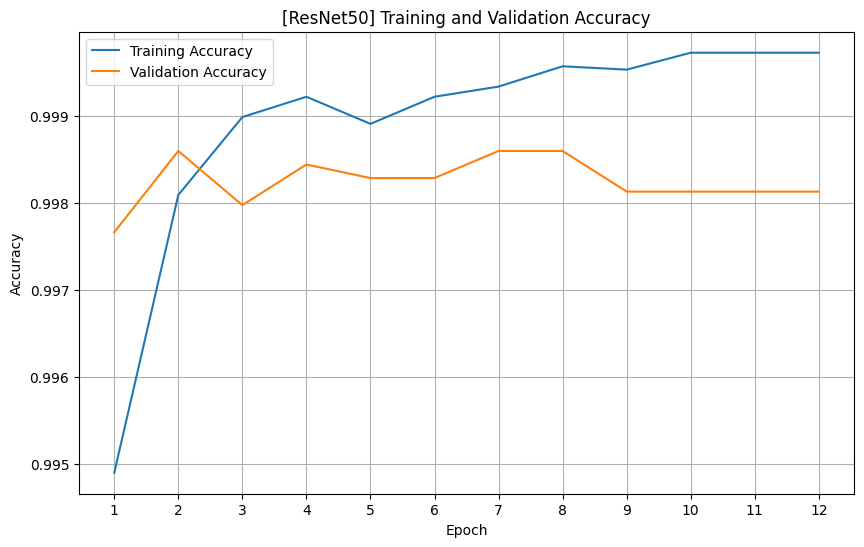

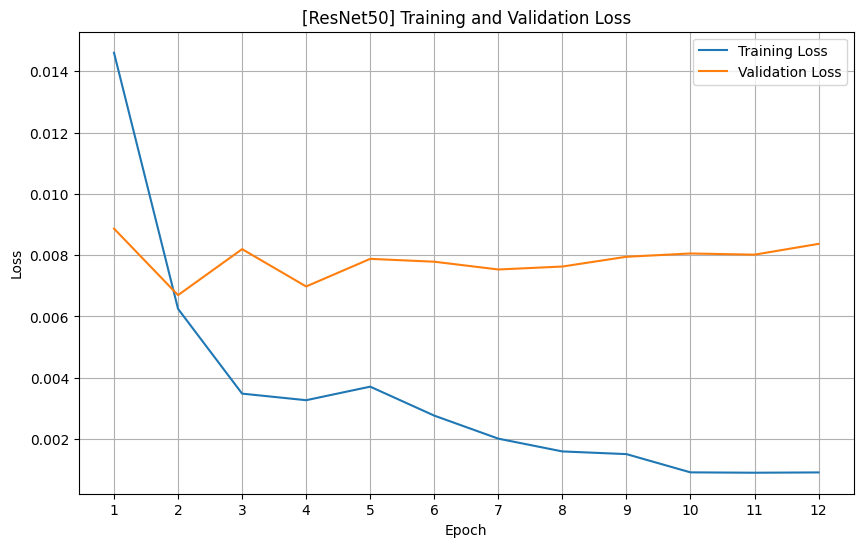

Number of False Positives: 2


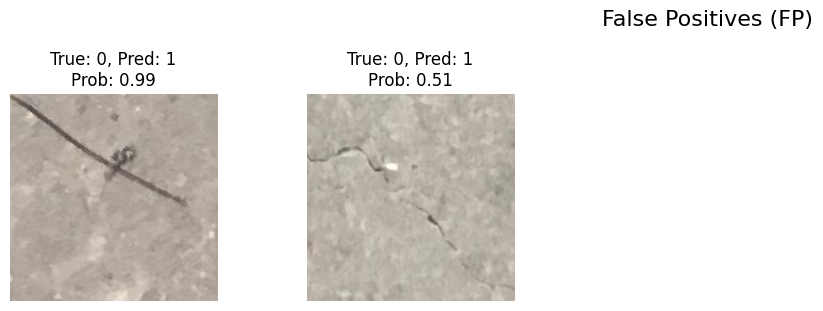

Number of False Negatives: 7


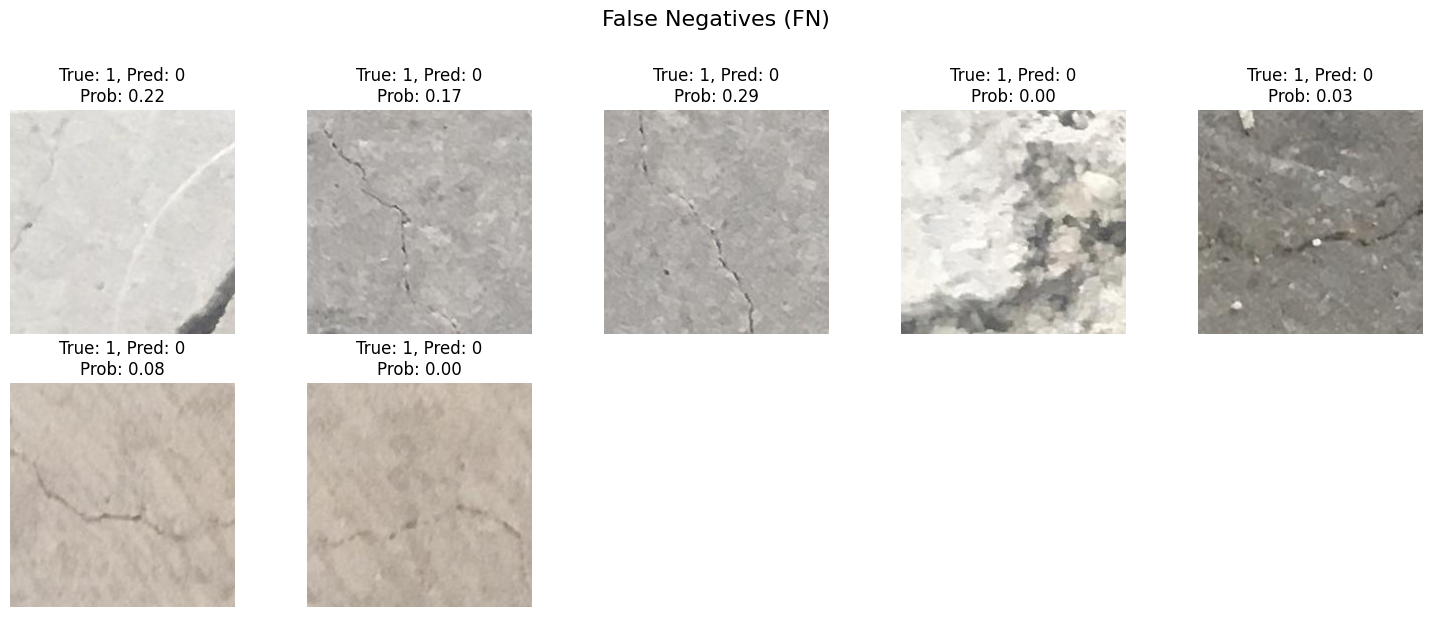

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,740,613 (102.01 MB)

 Trainable params: 1,050,625 (4.01 MB)

 Non-trainable params: 23,588,736 (89.98 MB)

 Optimizer params: 2,101,252 (8.02 MB)

In [52]:
# Evaluate and visualize the performance
print_classification_report(resnet_y_true, resnet_y_pred_classes, ['Negative', 'Positive'], 'ResNet50')
plot_roc(resnet_y_true, resnet_y_pred, 'ResNet50')
plot_confusion_matrix(resnet_y_true, resnet_y_pred_classes, 'ResNet50')
plot_training_history(resnet_history, 'ResNet50')
plot_misclassified_samples(resnet_mis)

resnet_model.summary()

## 5.3 EfficientNetB0

Found 25686 images belonging to 2 classes.
Found 6421 images belonging to 2 classes.
Epoch 1/30
803/803 ━━━━━━━━━━━━━━━━━━━━ 108s 102ms/step - accuracy: 0.9726 - loss: 0.0700 - val_accuracy: 0.9972 - val_loss: 0.0087 - learning_rate: 1.0000e-04
Epoch 2/30
803/803 ━━━━━━━━━━━━━━━━━━━━ 69s 85ms/step - accuracy: 0.9963 - loss: 0.0131 - val_accuracy: 0.9977 - val_loss: 0.0065 - learning_rate: 1.0000e-04
Epoch 3/30
803/803 ━━━━━━━━━━━━━━━━━━━━ 63s 77ms/step - accuracy: 0.9978 - loss: 0.0087 - val_accuracy: 0.9977 - val_loss: 0.0086 - learning_rate: 1.0000e-04
Epoch 4/30
803/803 ━━━━━━━━━━━━━━━━━━━━ 61s 75ms/step - accuracy: 0.9976 - loss: 0.0070 - val_accuracy: 0.9975 - val_loss: 0.0080 - learning_rate: 1.0000e-04
Epoch 5/30
803/803 ━━━━━━━━━━━━━━━━━━━━ 79s 98ms/step - accuracy: 0.9971 - loss: 0.0089 - val_accuracy: 0.9981 - val_loss: 0.0057 - learning_rate: 1.0000e-04
Epoch 6/30
803/803 ━━━━━━━━━━━━━━━━━━━━ 131s 162ms/step - accuracy: 0.9986 - loss: 0.0061 - val_accuracy: 0.9983 - val_loss

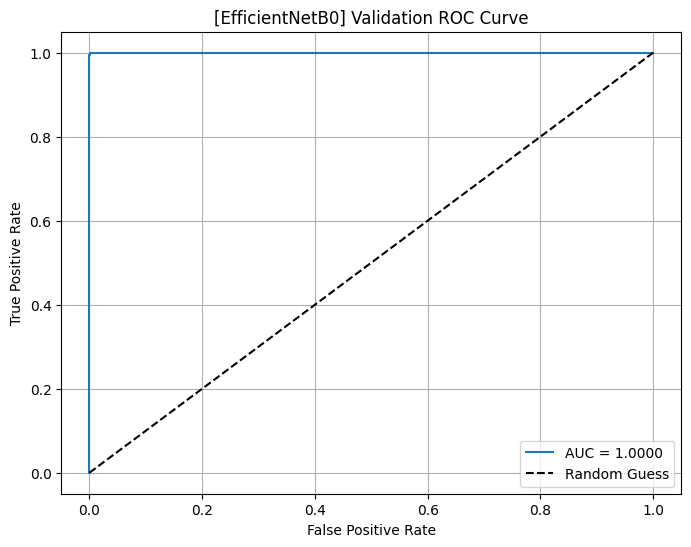

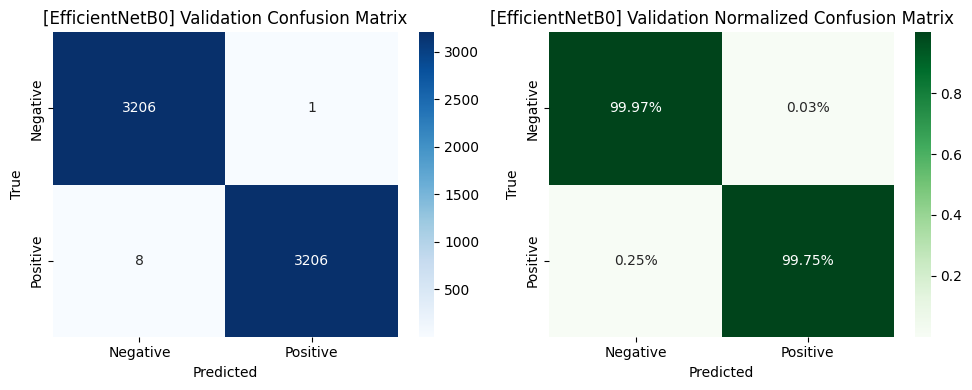

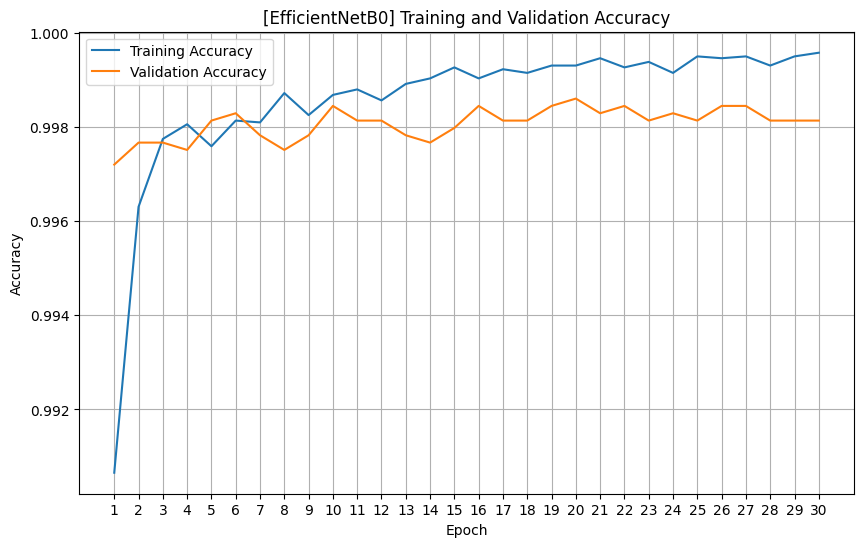

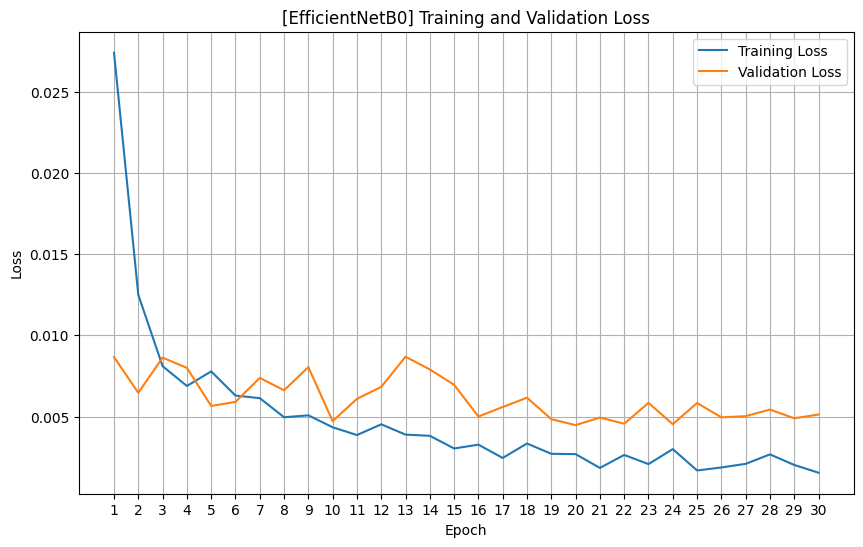

Number of False Positives: 1


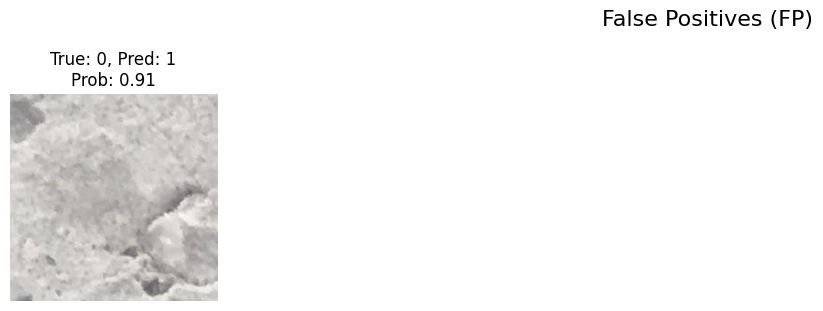

Number of False Negatives: 8


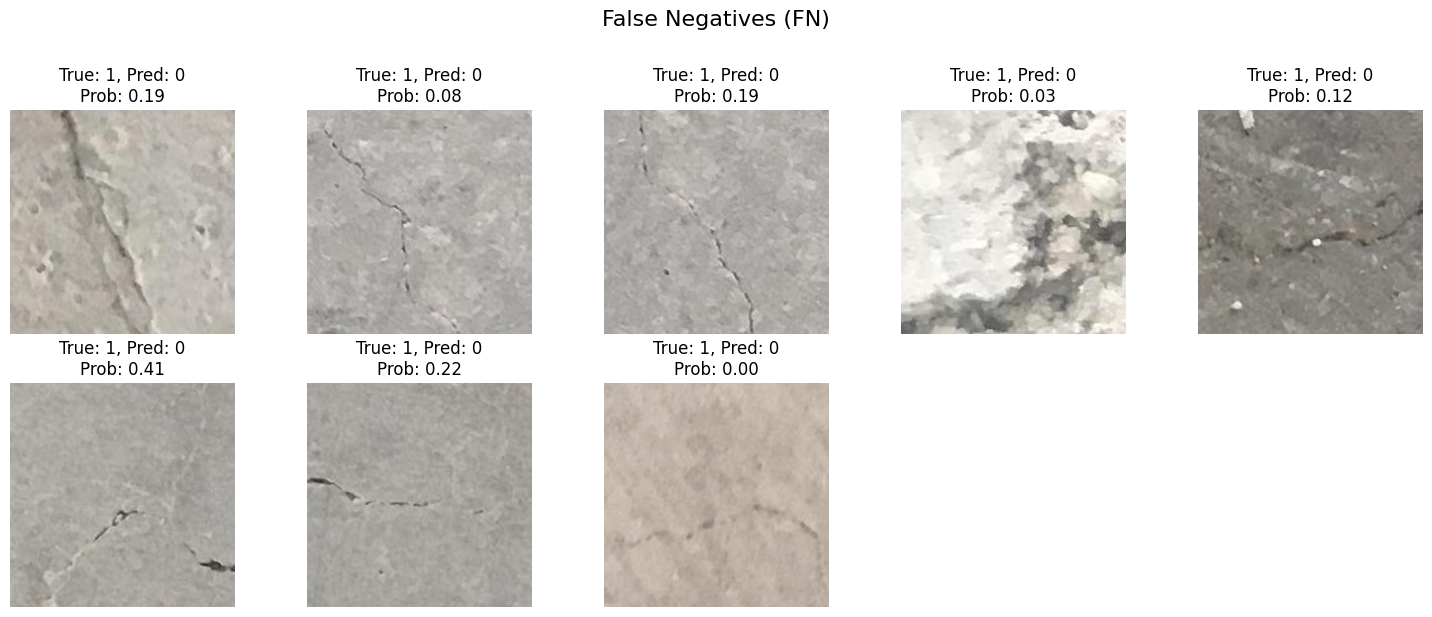

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,022,824 (22.98 MB)

 Trainable params: 657,409 (2.51 MB)

 Non-trainable params: 4,050,595 (15.45 MB)

 Optimizer params: 1,314,820 (5.02 MB)

In [53]:
# Generate data for EfficientNetB0
train_generator_efficientnet, val_generator_efficientnet, test_generator_efficientnet = gen(
    efficientnet.preprocess_input, train_dir, test_dir, image_size=(224, 224), batch_size=BATCH_SIZE
)

# Start time
efficientnet_start_time = time.time()

# Build and fit EfficientNetB0 model
efficientnet_model, efficientnet_history = build_and_fit_model(
    efficientnet.EfficientNetB0, 
    train_generator=train_generator_efficientnet, 
    val_generator=val_generator_efficientnet, 
    input_shape=(224, 224, 3), 
    epochs=EPOCHS
)

# End time
efficientnet_end_time = time.time()
# Calculate average epoch time
efficientnet_total_time = int(efficientnet_end_time - efficientnet_start_time)
efficientnet_num_epochs = len(efficientnet_history.history['loss'])
efficientnet_avg_epoch_time = efficientnet_total_time // efficientnet_num_epochs
print("Average epoch time of EfficientNetB0:", efficientnet_avg_epoch_time, "seconds")
print("Total number of epochs:", efficientnet_num_epochs)
print("Total time of EfficientNetB0:", efficientnet_total_time, "seconds")

# Predict on validation set for EfficientNetB0
efficientnet_y_pred, efficientnet_y_pred_classes, efficientnet_y_true, efficientnet_mis = predict_on_val(
    efficientnet_model, val_generator_efficientnet
)


# Evaluate and visualize EfficientNetB0 results
print_classification_report(efficientnet_y_true, efficientnet_y_pred_classes, ['Negative', 'Positive'], 'EfficientNetB0')
plot_roc(efficientnet_y_true, efficientnet_y_pred, 'EfficientNetB0')
plot_confusion_matrix(efficientnet_y_true, efficientnet_y_pred_classes, 'EfficientNetB0')
plot_training_history(efficientnet_history, 'EfficientNetB0')

plot_misclassified_samples(efficientnet_mis)

efficientnet_model.summary()

## 5.4 DenseNet121

Found 25686 images belonging to 2 classes.
Found 6421 images belonging to 2 classes.
Epoch 1/30
803/803 ━━━━━━━━━━━━━━━━━━━━ 108s 109ms/step - accuracy: 0.9576 - loss: 0.1002 - val_accuracy: 0.9967 - val_loss: 0.0110 - learning_rate: 1.0000e-04
Epoch 2/30
803/803 ━━━━━━━━━━━━━━━━━━━━ 69s 86ms/step - accuracy: 0.9964 - loss: 0.0113 - val_accuracy: 0.9977 - val_loss: 0.0079 - learning_rate: 1.0000e-04
Epoch 3/30
803/803 ━━━━━━━━━━━━━━━━━━━━ 69s 85ms/step - accuracy: 0.9985 - loss: 0.0066 - val_accuracy: 0.9980 - val_loss: 0.0083 - learning_rate: 1.0000e-04
Epoch 4/30
803/803 ━━━━━━━━━━━━━━━━━━━━ 69s 85ms/step - accuracy: 0.9989 - loss: 0.0044 - val_accuracy: 0.9980 - val_loss: 0.0081 - learning_rate: 1.0000e-04
Epoch 5/30
803/803 ━━━━━━━━━━━━━━━━━━━━ 71s 87ms/step - accuracy: 0.9989 - loss: 0.0045 - val_accuracy: 0.9980 - val_loss: 0.0074 - learning_rate: 1.0000e-04
Epoch 6/30
803/803 ━━━━━━━━━━━━━━━━━━━━ 69s 85ms/step - accuracy: 0.9984 - loss: 0.0064 - val_accuracy: 0.9980 - val_loss: 

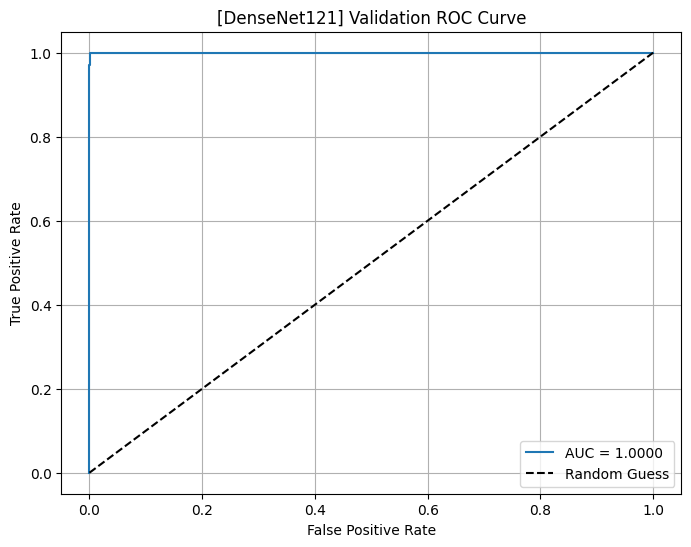

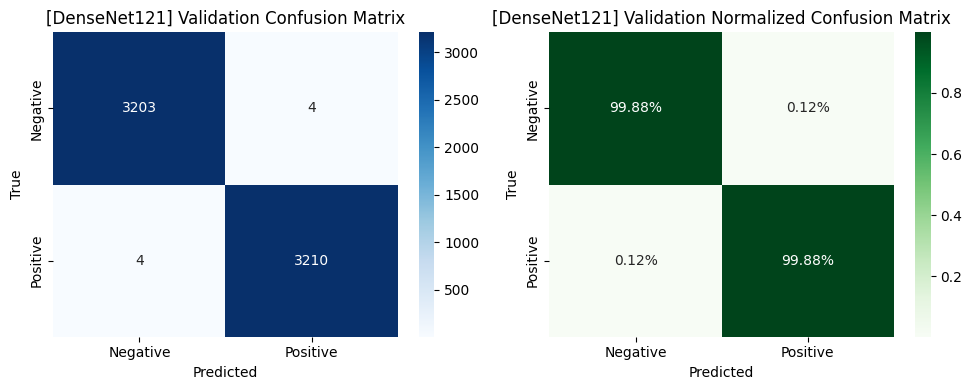

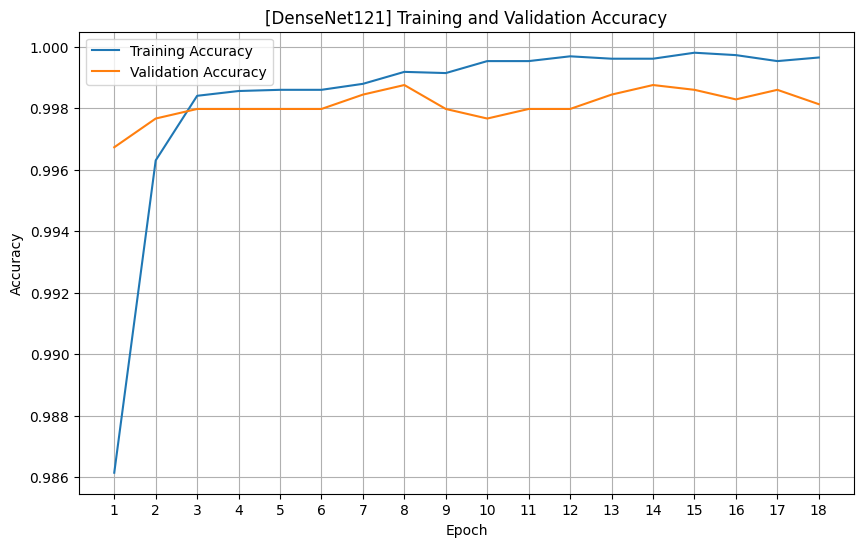

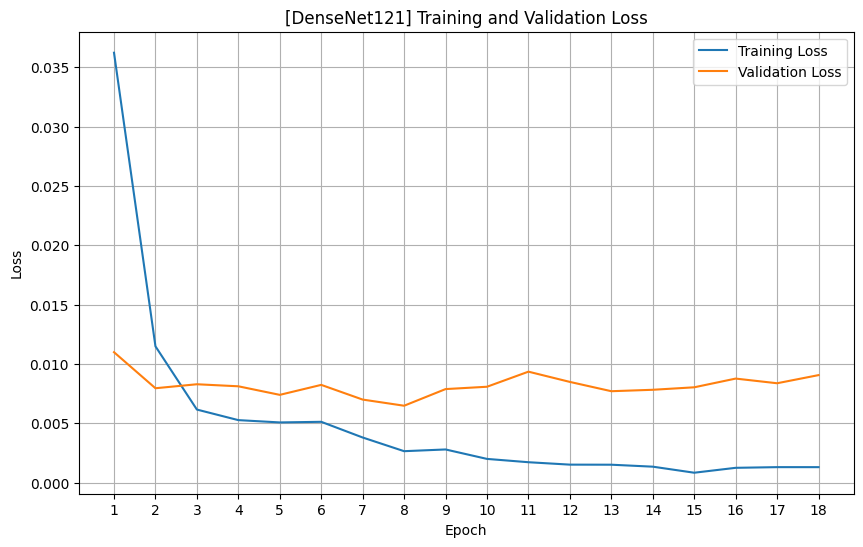

Number of False Positives: 4


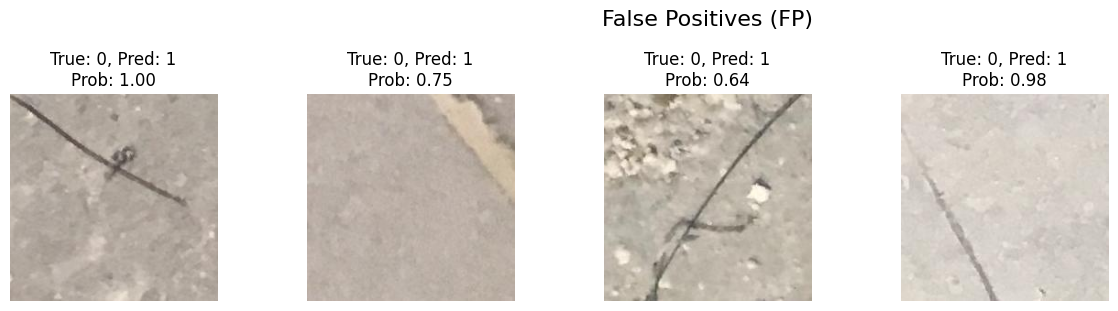

Number of False Negatives: 4


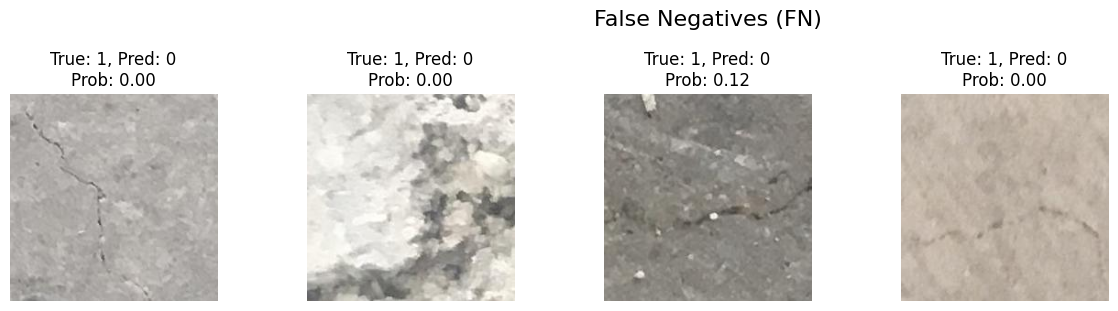

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,617,541 (32.87 MB)

 Trainable params: 526,337 (2.01 MB)

 Non-trainable params: 7,038,528 (26.85 MB)

 Optimizer params: 1,052,676 (4.02 MB)

In [54]:
# Generate data for DenseNet121
train_generator_densenet, val_generator_densenet, test_generator_densenet = gen(
    densenet.preprocess_input, train_dir, test_dir, image_size=(224, 224), batch_size=BATCH_SIZE
)

# Start time
densenet_start_time = time.time()

# Build and fit DenseNet121 model
densenet_model, densenet_history = build_and_fit_model(
    densenet.DenseNet121, 
    train_generator=train_generator_densenet, 
    val_generator=val_generator_densenet, 
    input_shape=(224, 224, 3), 
    epochs=EPOCHS
)

# End time
densenet_end_time = time.time()
# Calculate average epoch time
densenet_total_time = int(densenet_end_time - densenet_start_time)
densenet_num_epochs = len(densenet_history.history['loss'])
densenet_avg_epoch_time = densenet_total_time // densenet_num_epochs
print("Average epoch time of DenseNet121:", densenet_avg_epoch_time, "seconds")
print("Total number of epochs:", densenet_num_epochs)
print("Total time of DenseNet121:", densenet_total_time, "seconds")

# Predict on validation set for DenseNet121
densenet_y_pred, densenet_y_pred_classes, densenet_y_true, densenet_mis = predict_on_val(
    densenet_model, val_generator_densenet
)

# Evaluate and visualize DenseNet121 results
print_classification_report(densenet_y_true, densenet_y_pred_classes, ['Negative', 'Positive'], 'DenseNet121')
plot_roc(densenet_y_true, densenet_y_pred, 'DenseNet121')
plot_confusion_matrix(densenet_y_true, densenet_y_pred_classes, 'DenseNet121')
plot_training_history(densenet_history, 'DenseNet121')

plot_misclassified_samples(densenet_mis)

densenet_model.summary()

## 5.5 MobileNetV2

Found 25686 images belonging to 2 classes.
Found 6421 images belonging to 2 classes.
Epoch 1/30
803/803 ━━━━━━━━━━━━━━━━━━━━ 71s 78ms/step - accuracy: 0.9761 - loss: 0.0589 - val_accuracy: 0.9974 - val_loss: 0.0091 - learning_rate: 1.0000e-04
Epoch 2/30
803/803 ━━━━━━━━━━━━━━━━━━━━ 57s 70ms/step - accuracy: 0.9974 - loss: 0.0076 - val_accuracy: 0.9981 - val_loss: 0.0084 - learning_rate: 1.0000e-04
Epoch 3/30
803/803 ━━━━━━━━━━━━━━━━━━━━ 58s 72ms/step - accuracy: 0.9983 - loss: 0.0041 - val_accuracy: 0.9977 - val_loss: 0.0089 - learning_rate: 1.0000e-04
Epoch 4/30
803/803 ━━━━━━━━━━━━━━━━━━━━ 55s 68ms/step - accuracy: 0.9985 - loss: 0.0044 - val_accuracy: 0.9978 - val_loss: 0.0090 - learning_rate: 1.0000e-04
Epoch 5/30
803/803 ━━━━━━━━━━━━━━━━━━━━ 55s 67ms/step - accuracy: 0.9989 - loss: 0.0056 - val_accuracy: 0.9980 - val_loss: 0.0107 - learning_rate: 1.0000e-04
Epoch 6/30
803/803 ━━━━━━━━━━━━━━━━━━━━ 57s 71ms/step - accuracy: 0.9988 - loss: 0.0048 - val_accuracy: 0.9975 - val_loss: 0.

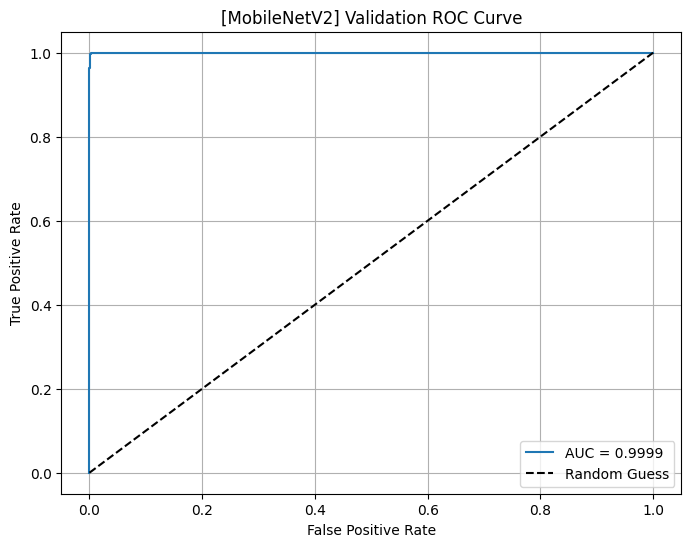

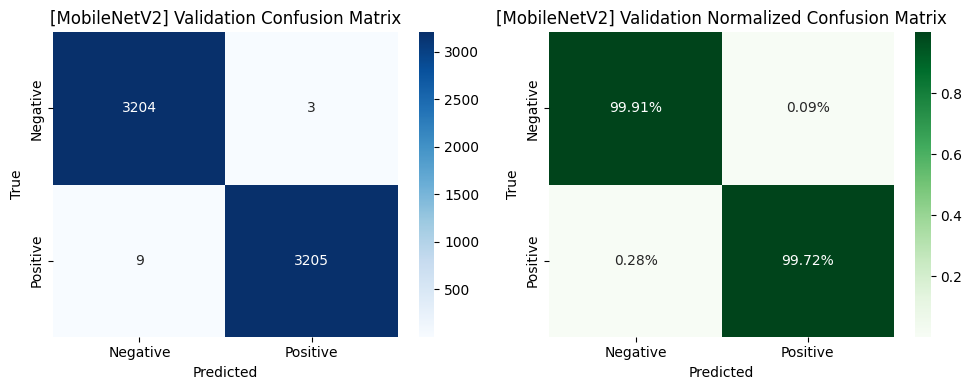

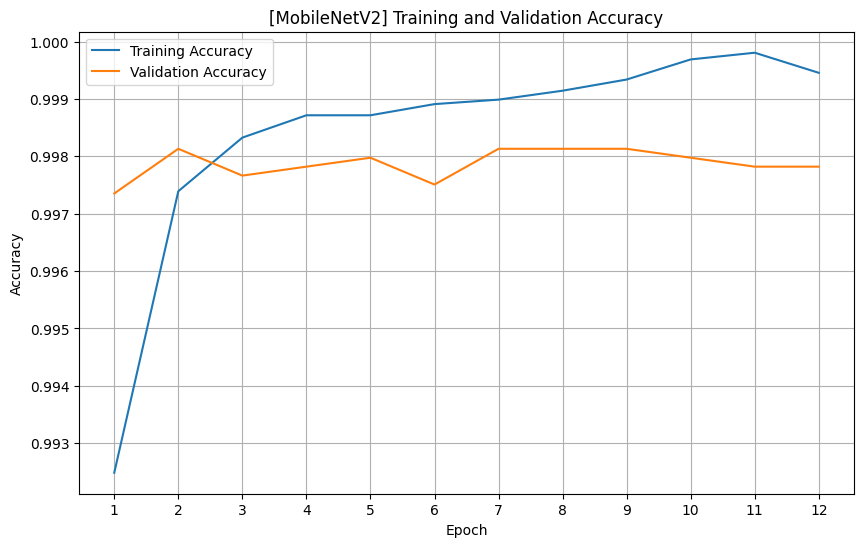

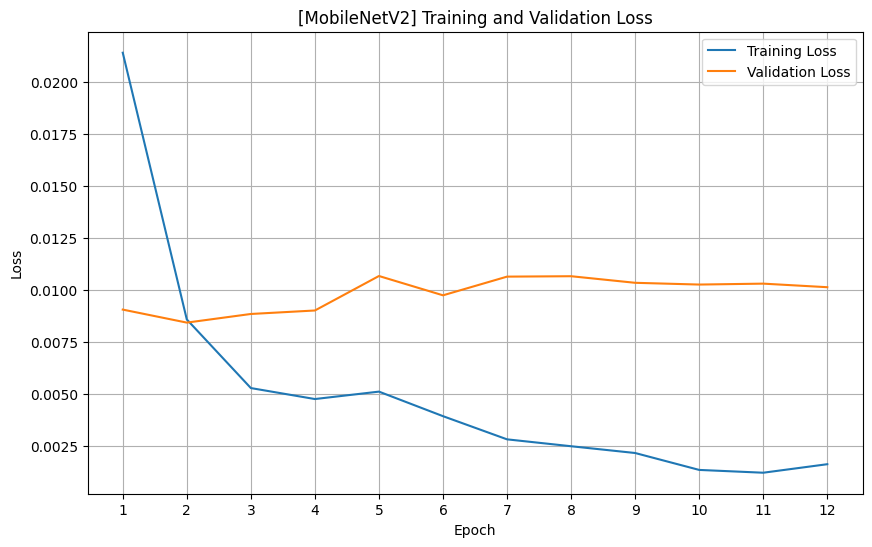

Number of False Positives: 3


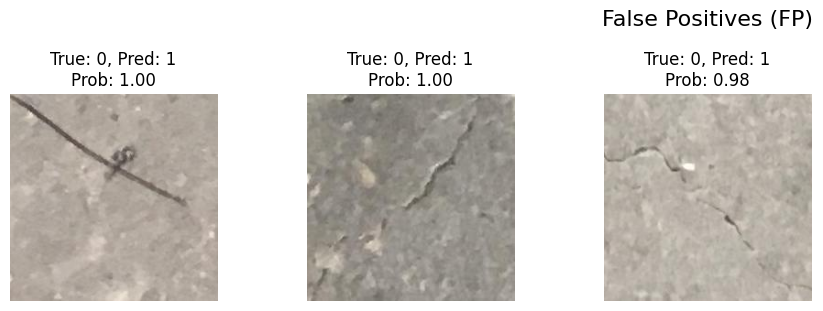

Number of False Negatives: 9


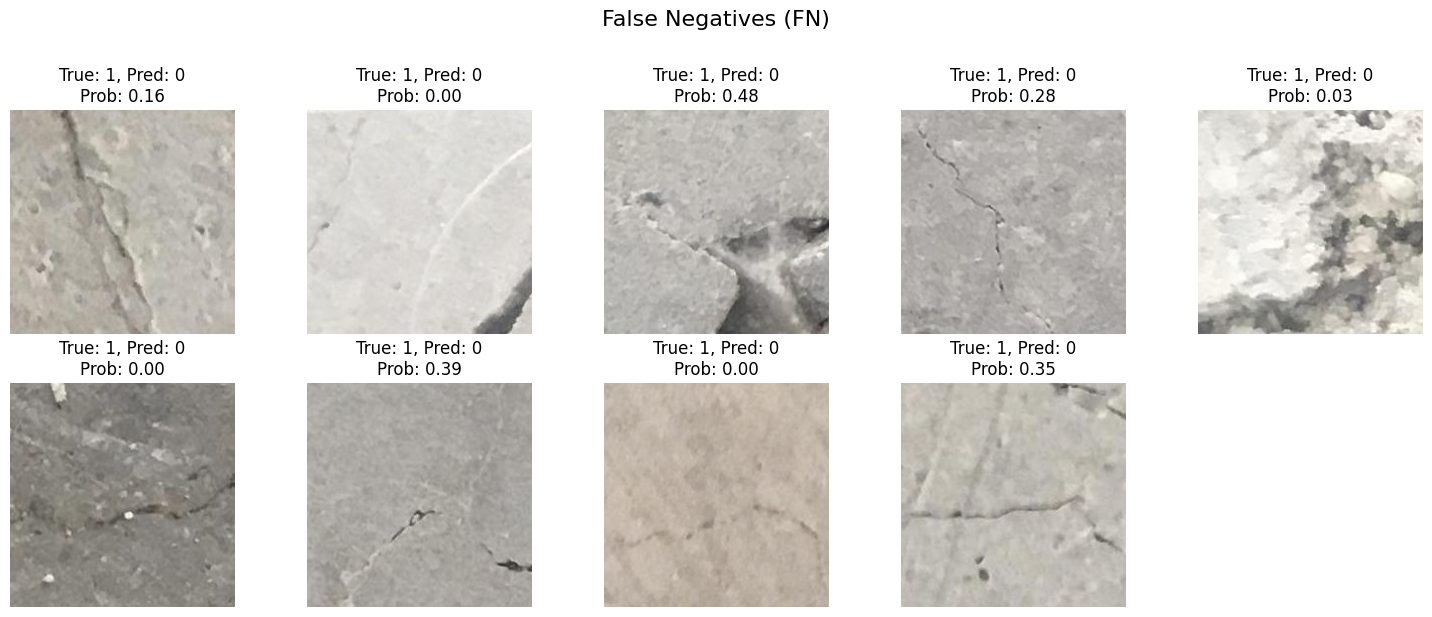

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,231,237 (16.14 MB)

 Trainable params: 657,409 (2.51 MB)

 Non-trainable params: 2,259,008 (8.62 MB)

 Optimizer params: 1,314,820 (5.02 MB)

In [55]:
# Generate data for MobileNetV2
train_generator_mobilenet, val_generator_mobilenet, test_generator_mobilenet = gen(
    mobilenet_v2.preprocess_input, train_dir, test_dir, image_size=(224, 224), batch_size=BATCH_SIZE
)

# Start time
mobilenet_start_time = time.time()

# Build and fit MobileNetV2 model
mobilenet_model, mobilenet_history = build_and_fit_model(
    mobilenet_v2.MobileNetV2, 
    train_generator=train_generator_mobilenet, 
    val_generator=val_generator_mobilenet, 
    input_shape=(224, 224, 3), 
    epochs=EPOCHS
)

# End time
mobilenet_end_time = time.time()
# Calculate average epoch time
mobilenet_total_time = int(mobilenet_end_time - mobilenet_start_time)
mobilenet_num_epochs = len(mobilenet_history.history['loss'])
mobilenet_avg_epoch_time = mobilenet_total_time // mobilenet_num_epochs
print("Average epoch time of MobileNetV2:", mobilenet_avg_epoch_time, "seconds")
print("Total number of epochs:", mobilenet_num_epochs)
print("Total time of MobileNetV2:", mobilenet_total_time, "seconds")

# Predict on validation set for MobileNetV2
mobilenet_y_pred, mobilenet_y_pred_classes, mobilenet_y_true, mobilenet_mis = predict_on_val(
    mobilenet_model, val_generator_mobilenet
)

# Evaluate and visualize MobileNetV2 results
print_classification_report(mobilenet_y_true, mobilenet_y_pred_classes, ['Negative', 'Positive'], 'MobileNetV2')
plot_roc(mobilenet_y_true, mobilenet_y_pred, 'MobileNetV2')
plot_confusion_matrix(mobilenet_y_true, mobilenet_y_pred_classes, 'MobileNetV2')
plot_training_history(mobilenet_history, 'MobileNetV2')

plot_misclassified_samples(mobilenet_mis)

mobilenet_model.summary()

# **6. Model Comparison**

## 6.1 Compute Metrics

In [66]:
# Function to compute metrics using y_true and y_pred
def compute_metrics(y_true, y_pred_prob, y_pred_classes, avg_epoch_time, num_epochs,total_time, model_name):
    # Calculate Validation Accuracy
    val_accuracy = accuracy_score(y_true, y_pred_classes)
    
    # Calculate Validation Loss using log loss
    val_loss = log_loss(y_true, y_pred_prob)
    
    # Calculate ROC AUC Score
    roc_auc = roc_auc_score(y_true, y_pred_prob)

    # Calculate confusion matrix and derived metrics
    cm = confusion_matrix(y_true, y_pred_classes)
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    return {
        'Model': model_name,
        'Validation Accuracy': val_accuracy,
        'Validation Loss': val_loss,
        'ROC AUC': roc_auc,
        'FP': fp,
        'FN': fn,
        'FPR': fpr,
        'FNR': fnr,
        'Avg Epoch Time (s)': avg_epoch_time,
        'Epochs': num_epochs,
        'Total Time (s)': total_time,
    }

# Extract metrics for each model
metrics_data = []
metrics_data.append(compute_metrics(custom_y_true, custom_y_pred, custom_y_pred_classes, custom_avg_epoch_time, custom_num_epochs, custom_total_time, 'Custom Model'))
metrics_data.append(compute_metrics(resnet_y_true, resnet_y_pred, resnet_y_pred_classes, resnet_avg_epoch_time, resnet_num_epochs, resnet_total_time, 'ResNet50'))
metrics_data.append(compute_metrics(efficientnet_y_true, efficientnet_y_pred, efficientnet_y_pred_classes, efficientnet_avg_epoch_time, efficientnet_num_epochs, efficientnet_total_time, 'EfficientNetB0'))
metrics_data.append(compute_metrics(densenet_y_true, densenet_y_pred, densenet_y_pred_classes, densenet_avg_epoch_time, densenet_num_epochs, densenet_total_time, 'DenseNet121'))
metrics_data.append(compute_metrics(mobilenet_y_true, mobilenet_y_pred, mobilenet_y_pred_classes, mobilenet_avg_epoch_time, mobilenet_num_epochs, mobilenet_total_time, 'MobileNetV2'))


# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Display DataFrame
metrics_df

Model  Validation Accuracy  Validation Loss   ROC AUC  FP  FN  \
0    Custom Model             0.996885         0.016159  0.999550   8  12   
1        ResNet50             0.998598         0.006696  0.999747   2   7   
2  EfficientNetB0             0.998598         0.004474  0.999985   1   8   
3     DenseNet121             0.998754         0.006473  0.999954   4   4   
4     MobileNetV2             0.998131         0.008441  0.999919   3   9   

        FPR       FNR  Avg Epoch Time (s)  Epochs  Total Time (s)  
0  0.002495  0.003734                  50      19             953  
1  0.000624  0.002178                  73      12             884  
2  0.000312  0.002489                  63      30            1891  
3  0.001247  0.001245                  71      18            1278  
4  0.000935  0.002800                  58      12             700

## 6.2 Visualization

<Figure size 1200x600 with 0 Axes>

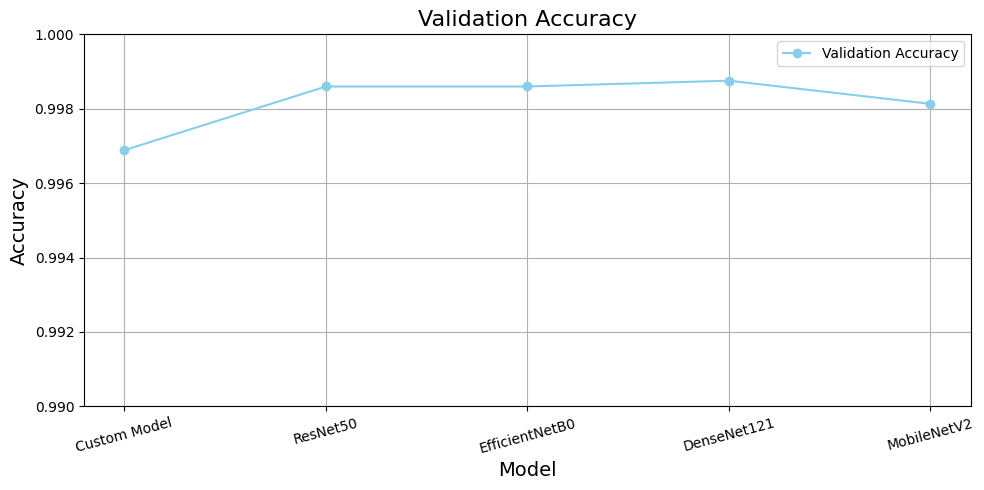

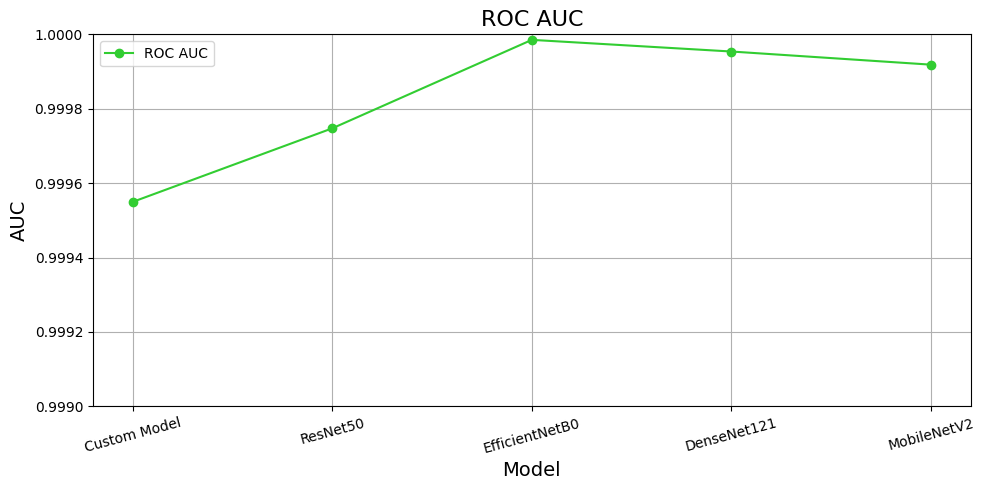

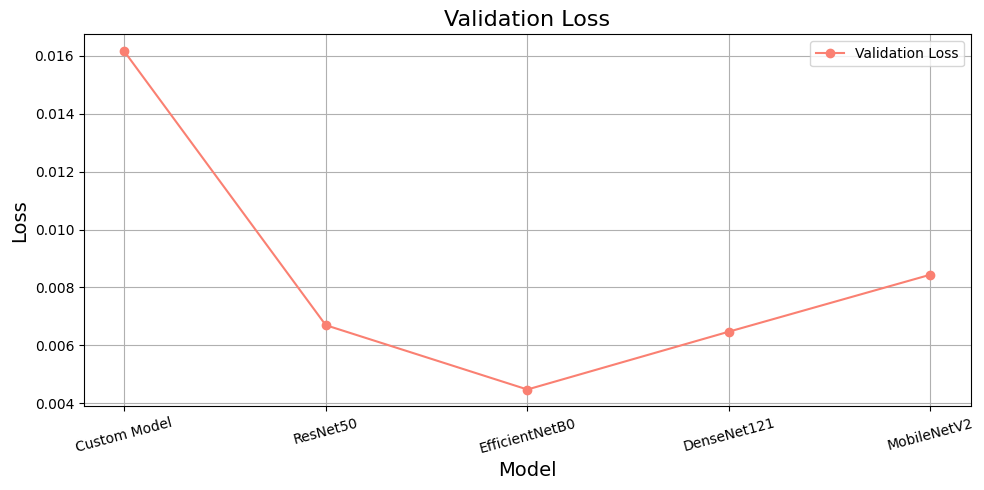

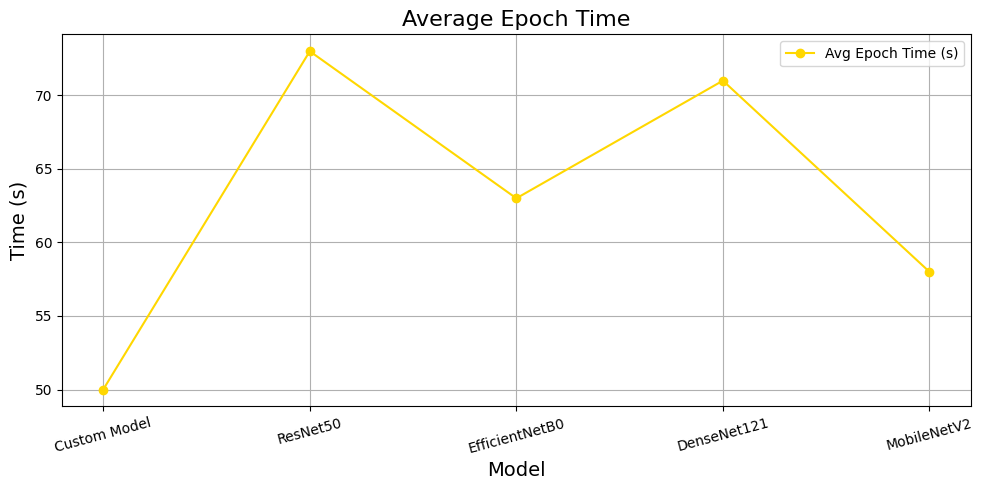

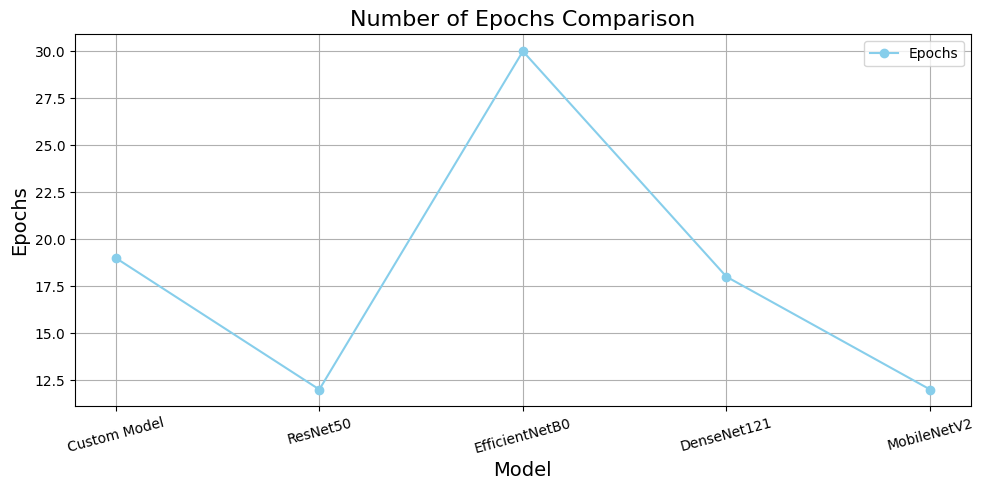

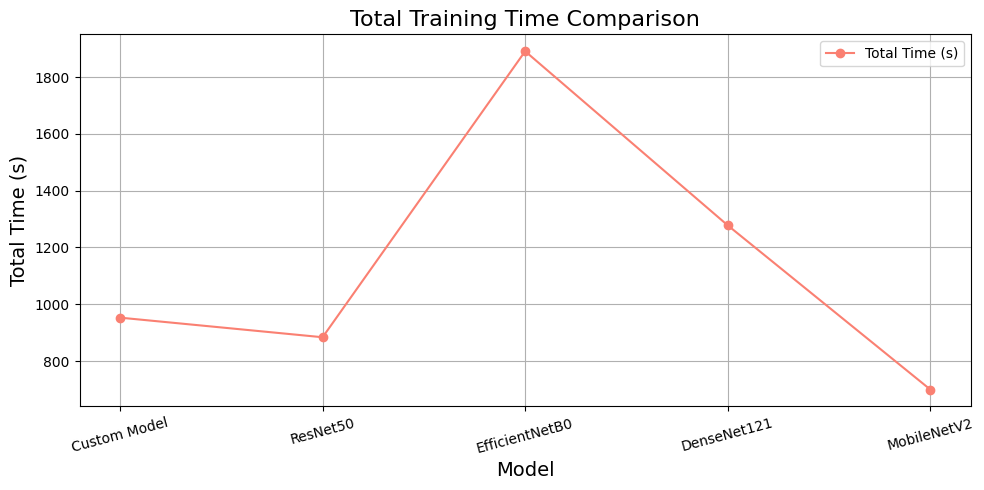

In [67]:
# Plot
plt.figure(figsize=(12, 6))

# Validation Accuracy Comparison
plt.figure(figsize=(10, 5))
plt.plot(metrics_df['Model'], metrics_df['Validation Accuracy'], marker='o', color='skyblue', label='Validation Accuracy')
plt.title('Validation Accuracy', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0.99, 1.0)  # Adjusted for better visualization
plt.xticks(metrics_df['Model'], rotation=15)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ROC AUC Comparison
plt.figure(figsize=(10, 5))
plt.plot(metrics_df['Model'], metrics_df['ROC AUC'], marker='o', color='limegreen', label='ROC AUC')
plt.title('ROC AUC', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('AUC', fontsize=14)
plt.ylim(0.999, 1.0)  # Adjusted for better visualization
plt.xticks(metrics_df['Model'], rotation=15)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Validation Loss Comparison
plt.figure(figsize=(10, 5))
plt.plot(metrics_df['Model'], metrics_df['Validation Loss'], marker='o', color='salmon', label='Validation Loss')
plt.title('Validation Loss', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(metrics_df['Model'], rotation=15)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Average Epoch Time Comparison
plt.figure(figsize=(10, 5))
plt.plot(metrics_df['Model'], metrics_df['Avg Epoch Time (s)'], marker='o', color='gold', label='Avg Epoch Time (s)')
plt.title('Average Epoch Time', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Time (s)', fontsize=14)
plt.xticks(metrics_df['Model'], rotation=15)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Epochs Comparison
plt.figure(figsize=(10, 5))
plt.plot(metrics_df['Model'], metrics_df['Epochs'], marker='o', color='skyblue', label='Epochs')
plt.title('Number of Epochs Comparison', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Epochs', fontsize=14)
plt.xticks(metrics_df['Model'], rotation=15)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Total Training Time Comparison
plt.figure(figsize=(10, 5))
plt.plot(metrics_df['Model'], metrics_df['Total Time (s)'], marker='o', color='salmon', label='Total Time (s)')
plt.title('Total Training Time Comparison', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Total Time (s)', fontsize=14)
plt.xticks(metrics_df['Model'], rotation=15)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



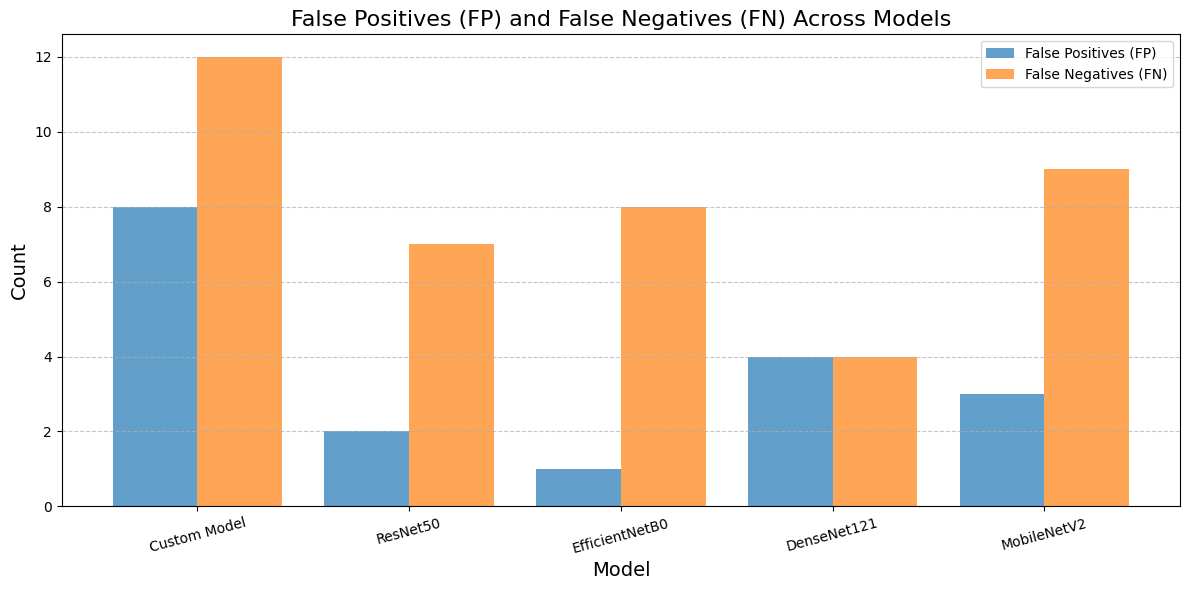

In [68]:
# Generate x-axis positions for each model
x = np.arange(len(metrics_df['Model']))

# Bar width for each bar
width = 0.4  

# Create the figure and axis
plt.figure(figsize=(12, 6))

# Plot the False Positives (FP) bars
plt.bar(x - width/2, metrics_df['FP'], width=width, label='False Positives (FP)', alpha=0.7)

# Plot the False Negatives (FN) bars
plt.bar(x + width/2, metrics_df['FN'], width=width, label='False Negatives (FN)', alpha=0.7)

# Add a title and axis labels
plt.title('False Positives (FP) and False Negatives (FN) Across Models', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Set x-axis tick labels and align them with the bars
plt.xticks(x, metrics_df['Model'], rotation=15)

# Add a gridline along the y-axis for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend to distinguish FP and FN
plt.legend()

# Automatically adjust subplot parameters for a clean layout
plt.tight_layout()

# Show the plot
plt.show()

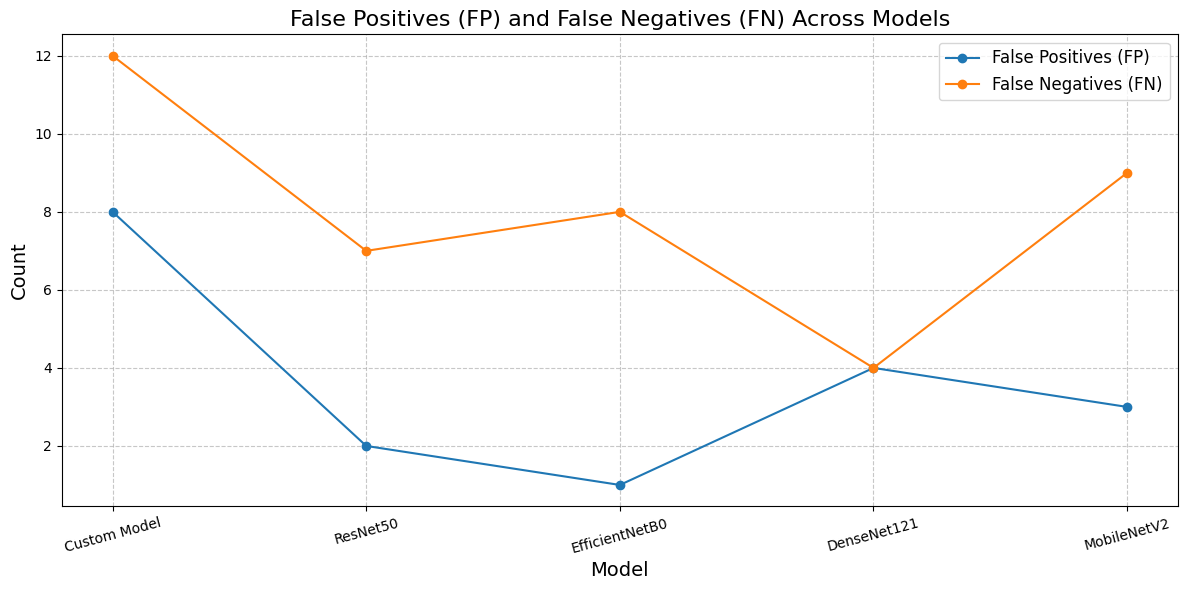

In [69]:
import matplotlib.ticker as mticker

# Plot FP and FN comparison using a line chart
plt.figure(figsize=(12, 6))
plt.plot(metrics_df['Model'], metrics_df['FP'], marker='o', linestyle='-', label='False Positives (FP)')
plt.plot(metrics_df['Model'], metrics_df['FN'], marker='o', linestyle='-', label='False Negatives (FN)')

# Title and labels
plt.title('False Positives (FP) and False Negatives (FN) Across Models', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Adjust y-axis to show only integers
plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

# Customize x-axis
plt.xticks(rotation=15)

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# Tight layout for better spacing
plt.tight_layout()
plt.show()


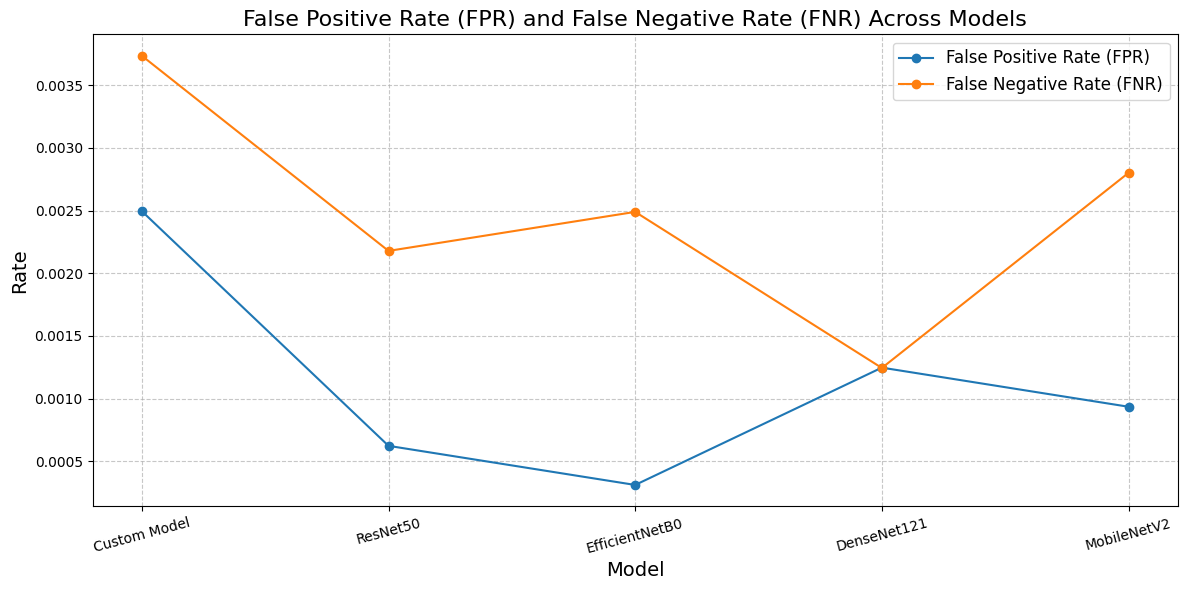

In [70]:
import matplotlib.ticker as mticker

# Plot FPR and FNR comparison using a line chart
plt.figure(figsize=(12, 6))
plt.plot(metrics_df['Model'], metrics_df['FPR'], marker='o', linestyle='-', label='False Positive Rate (FPR)')
plt.plot(metrics_df['Model'], metrics_df['FNR'], marker='o', linestyle='-', label='False Negative Rate (FNR)')

# Title and labels
plt.title('False Positive Rate (FPR) and False Negative Rate (FNR) Across Models', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Rate', fontsize=14)

# Customize x-axis
plt.xticks(rotation=15)

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# Tight layout for better spacing
plt.tight_layout()
plt.show()


# **7. Make Final Prediction**

## 7.1 Load Test Images

In [61]:
# Define function to generate batches of preprocessed images
def batch_load_images(directory, batch_size, image_size=(224, 224)):
    files = [f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    num_files = len(files)
    for i in range(0, num_files, batch_size):
        batch_files = files[i:i + batch_size]
        batch_images = []
        for file in batch_files:
            img_path = os.path.join(directory, file)
            img = load_img(img_path, target_size=image_size)
            img_array = img_to_array(img)
            img_array = resnet50.preprocess_input(img_array)
            batch_images.append(img_array)
        yield np.array(batch_images), batch_files

## 7.2 Retrain the Model and Make Final Prediction with Whole Dataset using Resnet50

In [62]:
# Extract the best epoch from the previous training process
# resnet_best_epoch = np.argmin(val_loss) + 1  
resnet_best_epoch = len(resnet_history.history['val_loss']) - np.argmin(resnet_history.history['val_loss'][::-1])
print("Best epoch from previous training:", resnet_best_epoch)

# Generate a new training data generator using 100% of the training data
# No validation split is used for this retraining process
train_generator_full, _, _ = gen(
    resnet50.preprocess_input, 
    train_dir, 
    test_dir, 
    image_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE
)

# Retrain the model using the entire training dataset and the best epoch
resnet_model, resnet_history_full = build_and_fit_model(
    base_model_name=resnet50.ResNet50,  # Use ResNet50 as the base model for transfer learning
    train_generator=train_generator_full,  # Training data generator with 100% of training data
    val_generator=None,  # No validation data for this retraining
    epochs=resnet_best_epoch  # Train for the number of epochs determined in the previous best training
)


Best epoch from previous training: 2
Found 25686 images belonging to 2 classes.
Found 6421 images belonging to 2 classes.
Epoch 1/2
803/803 ━━━━━━━━━━━━━━━━━━━━ 71s 72ms/step - accuracy: 0.9762 - loss: 0.0569 - learning_rate: 1.0000e-04
Epoch 2/2
803/803 ━━━━━━━━━━━━━━━━━━━━ 57s 70ms/step - accuracy: 0.9982 - loss: 0.0065 - learning_rate: 1.0000e-04


In [63]:
# Batch size
BATCH_SIZE = 32

# Predict on test set in batches
predictions = []
image_ids = []

for batch_images, batch_files in batch_load_images(test_dir, batch_size=BATCH_SIZE):
    batch_pred = resnet_model.predict(batch_images, verbose=0)  
    predictions.extend(batch_pred)
    image_ids.extend(batch_files)

# Remove file extensions from image_ids
image_ids = [os.path.splitext(img_id)[0] for img_id in image_ids]

# Convert probabilities to binary classes
predicted_classes = (np.array(predictions) > 0.5).astype(int).reshape(-1)

# Map class indices to labels
class_labels = {0: 'Negative', 1: 'Positive'}
predicted_labels = [class_labels[pred] for pred in predicted_classes]

# Create and save submission DataFrame
submission_df = pd.DataFrame({
    'image_id': image_ids,
    'predicted_class': predicted_labels
})
submission_df.to_csv('submission_v3_seed=6105_res.csv', index=False)

print("Submission file created: submission_v3_seed=6105_res.csv")

Submission file created: submission_v3_seed=6105_res.csv


## 7.3 Retrain the Model and Make Final Prediction with Whole Dataset using EfficientNetB0

In [64]:
# Extract the best epoch from the previous training process
efficientnet_best_epoch = len(resnet_history.history['val_loss']) - np.argmin(resnet_history.history['val_loss'][::-1])
print("Best epoch from previous training:", efficientnet_best_epoch)

# Generate a new training data generator using 100% of the training data
# No validation split is used for this retraining process
train_generator_full, _, _ = gen(
    efficientnet.preprocess_input, 
    train_dir, 
    test_dir, 
    image_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE
)

# Retrain the model using the entire training dataset and the best epoch
efficientnet_model, efficientnet_history_full = build_and_fit_model(
    base_model_name=efficientnet.EfficientNetB0,  # Use EfficientNetB0 as the base model for transfer learning
    train_generator=train_generator_full,  # Training data generator with 100% of training data
    val_generator=None,  # No validation data for this retraining
    epochs=efficientnet_best_epoch  # Train for the number of epochs determined in the previous best training
)

Best epoch from previous training: 2
Found 25686 images belonging to 2 classes.
Found 6421 images belonging to 2 classes.
Epoch 1/2
803/803 ━━━━━━━━━━━━━━━━━━━━ 92s 81ms/step - accuracy: 0.9782 - loss: 0.0547 - learning_rate: 1.0000e-04
Epoch 2/2
803/803 ━━━━━━━━━━━━━━━━━━━━ 45s 55ms/step - accuracy: 0.9958 - loss: 0.0113 - learning_rate: 1.0000e-04


In [65]:
# Batch size
BATCH_SIZE = 32

# Predict on test set in batches
predictions = []
image_ids = []

for batch_images, batch_files in batch_load_images(test_dir, batch_size=BATCH_SIZE):
    batch_pred = efficientnet_model.predict(batch_images, verbose=0)  
    predictions.extend(batch_pred)
    image_ids.extend(batch_files)

# Remove file extensions from image_ids
image_ids = [os.path.splitext(img_id)[0] for img_id in image_ids]

# Convert probabilities to binary classes
predicted_classes = (np.array(predictions) > 0.5).astype(int).reshape(-1)

# Map class indices to labels
class_labels = {0: 'Negative', 1: 'Positive'}
predicted_labels = [class_labels[pred] for pred in predicted_classes]

# Create and save submission DataFrame
submission_df = pd.DataFrame({
    'image_id': image_ids,
    'predicted_class': predicted_labels
})
submission_df.to_csv('submission_v3_seed=6105_eff.csv', index=False)

print("Submission file created: submission_v3_seed=6105_eff.csv")

Submission file created: submission_v3_seed=6105_eff.csv


## 7.4 DenseNet121

In [ ]:
# Extract the best epoch from the previous training process
# Calculate the number of epochs where validation loss was minimized
densenet_best_epoch = len(densenet_history.history['val_loss']) - np.argmin(densenet_history.history['val_loss'][::-1])
print("Best epoch from previous training:", densenet_best_epoch)

# Generate a new training data generator using 100% of the training data
# No validation split is used for this retraining process
train_generator_full, _, _ = gen(
    densenet.preprocess_input, 
    train_dir, 
    test_dir, 
    image_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE
)

# Retrain the model using the entire training dataset and the best epoch
densenet_model, densenet_history_full = build_and_fit_model(
    base_model_name=densenet.DenseNet121,  # Use DenseNet121 as the base model for transfer learning
    train_generator=train_generator_full,  # Training data generator with 100% of training data
    val_generator=None,  # No validation data for this retraining
    epochs=densenet_best_epoch  # Train for the number of epochs determined in the previous best training
)

# Batch size
BATCH_SIZE = 32

# Predict on test set in batches
predictions = []
image_ids = []

for batch_images, batch_files in batch_load_images(test_dir, batch_size=BATCH_SIZE):
    batch_pred = densenet_model.predict(batch_images, verbose=0)  
    predictions.extend(batch_pred)
    image_ids.extend(batch_files)

# Remove file extensions from image_ids

image_ids = [os.path.splitext(img_id)[0] for img_id in image_ids]

# Convert probabilities to binary classes
predicted_classes = (np.array(predictions) > 0.5).astype(int).reshape(-1)

# Map class indices to labels
class_labels = {0: 'Negative', 1: 'Positive'}
predicted_labels = [class_labels[pred] for pred in predicted_classes]

# Create and save submission DataFrame
submission_df = pd.DataFrame({
    'image_id': image_ids,
    'predicted_class': predicted_labels
})
submission_df.to_csv('submission_v3_seed=6105_den.csv', index=False)

print("Submission file created: submission_v3_seed=6105_den.csv")


Best epoch from previous training: 8
Found 25686 images belonging to 2 classes.
Found 6421 images belonging to 2 classes.
